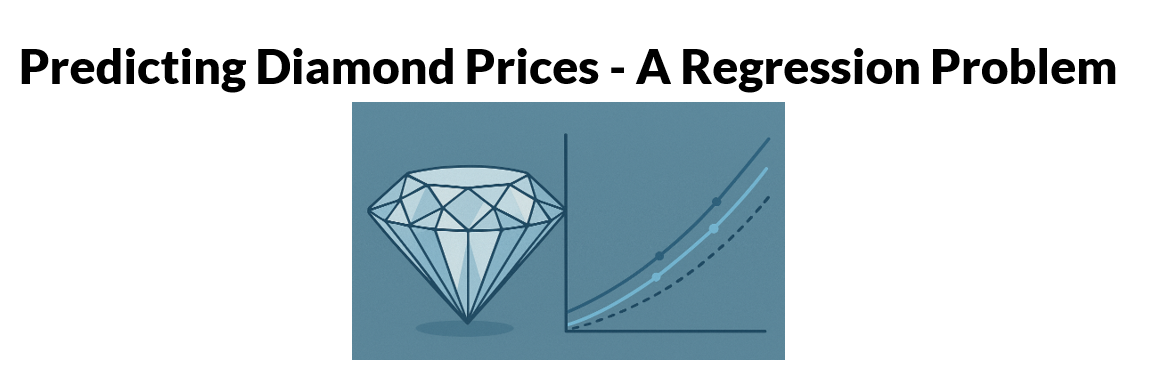

# <u><font color=#000080>Project Overview</u></font>


Accurate diamond price prediction helps sellers and buyers ensure fair pricing and transparency in marketplaces.

This project encompassed building a highly accurate model for predicting diamond prices by understanding the interplay of key quality indicators(`cut`, `color`, `clarity`) and size-related features (`carat`, `depth`, `table`, and overall dimensions).

Using the Kaggle diamonds dataset, which contains 53,940 observations, we applied a rigorous workflow to ensure reliable and practical model performance. This included thorough data cleaning, strategic feature selection, and experimentation with a range of machine learning algorithms, from a baseline linear regression model to advanced ensemble methods such as XGBoost, which was further refined through targeted hyperparameter tuning.

The objective was to identify the most influential pricing factors while delivering the most precise and explainable model that the data meaningfully supports.




# <u><font color=#000080>1. About the data</font></u>




Data Source: https://www.kaggle.com/code/nancyalaswad90/diamonds-prices-ideas

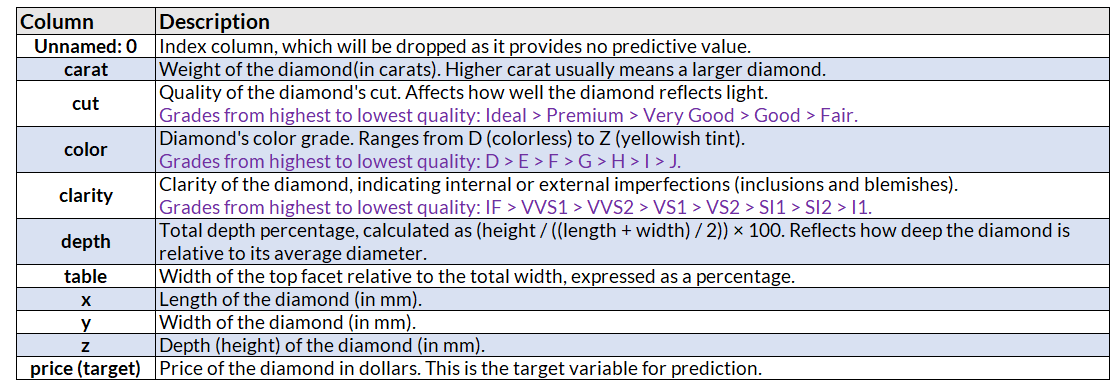

# <u><font color=#000080>2. Load Packages and Dependencies</font></u>

In [ ]:
%%capture

!pip install category_encoders
!pip install optuna


## Core data manipulation and visualization libraries
from google.colab import userdata # Kaggle API key in Colab
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Statistical analysis and utility libraries
import scipy.stats as stats
from itertools import combinations
from scipy.stats import chi2_contingency # Chi-squared test

## Statsmodels for advanced statistical modeling
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols # ANOVA
from statsmodels.stats.outliers_influence import variance_inflation_factor #  VIF calculation


# Scikit-learn for machine learning tasks
from sklearn.preprocessing import StandardScaler, PolynomialFeatures # StandardScaler for numerical feature scaling, PolynomialFeatures for interaction terms
from category_encoders import TargetEncoder # For encoding categorical features
from sklearn.model_selection import train_test_split, cross_val_score # For data splitting and cross-validation
from sklearn.linear_model import (
    LinearRegression,
    Ridge, RidgeCV,  # Ridge and its cross-validated version
    Lasso, LassoCV,  # Lasso and its cross-validated version
    ElasticNet, ElasticNetCV # ElasticNet and its cross-validated version
) # All linear regression models and their cross-validated tuning versions
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor # Tree-based ensemble models
from sklearn.metrics import mean_squared_error, r2_score # For model evaluation

# XGBoost for extreme gradient boosting
import xgboost as xgb
from xgboost import XGBRegressor
import optuna  # For hyperparameter optimization (Bayesian Optimization)
import shap    # For model interpretability (SHAP values)

# <u><font color=#000080>3.  Collection</font></u>




In [ ]:
## Upload  API Key to Colab
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

## Downlaod dataset directly into Colab
!kaggle datasets download -d nancyalaswad90/diamonds-prices

Dataset URL: https://www.kaggle.com/datasets/nancyalaswad90/diamonds-prices
License(s): CC-BY-NC-SA-4.0
  0% 0.00/711k [00:00<?, ?B/s]
100% 711k/711k [00:00<00:00, 869MB/s]


In [ ]:
## Unzip the Dataset
with zipfile.ZipFile("diamonds-prices.zip", 'r') as zip_ref:
    zip_ref.extractall("diamond_prices")

# <u><font color=#000080>4. Load and Glimpse Data</font></u>

In [ ]:
data = pd.read_csv('diamond_prices/Diamonds Prices2022.csv')
data.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [ ]:
## Display the minimum and maximum carat weights in the dataset
min_carat = data['carat'].min()
max_carat = data['carat'].max()
print(
    f'The smallest diamond in the dataset weighs {min_carat} carats ({(min_carat/0.005)/1000 :.2f} gram)'
    f'and the largest diamond in the dataset weighs {max_carat} carats ({(max_carat/0.005)/1000:.2f} gram).'
    )

The smallest diamond in the dataset weighs 0.2 carats (0.04 gram)and the largest diamond in the dataset weighs 5.01 carats (1.00 gram).


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53943 entries, 0 to 53942
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53943 non-null  int64  
 1   carat       53943 non-null  float64
 2   cut         53943 non-null  object 
 3   color       53943 non-null  object 
 4   clarity     53943 non-null  object 
 5   depth       53943 non-null  float64
 6   table       53943 non-null  float64
 7   price       53943 non-null  int64  
 8   x           53943 non-null  float64
 9   y           53943 non-null  float64
 10  z           53943 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


<font size=4, color=#4169E1>💎**OBSERVATIONS**</font>

* There are no missing values in this dataset.
* We can drop the column `Unnamed:0` as it will not provide any predictive value to our model.

# <u><font color=#000080>5. Data Cleaning</font></u>

In [ ]:
## Check for duplicates
print(f'Number of duplicated rows : {data.duplicated().sum()}')

Number of duplicated rows : 0


In [ ]:
## Display the initial numerical summary
data.describe()

,Unnamed: 0,carat,depth,table,price,x,y,z
count,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000
mean,26972.000000,0.797935,61.749322,57.457251,3932.734294,5.731158,5.734526,3.538730
std,15572.147122,0.473999,1.432626,2.234549,3989.338447,1.121730,1.142103,0.705679
min,1.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,13486.500000,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,26972.000000,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,40457.500000,1.040000,62.500000,59.000000,5324.000000,6.540000,6.540000,4.040000
max,53943.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


<font size=4, color=#4169E1>💎**OBSERVATIONS**</font>

The physical dimensions x, y, and z exhibit minimum values of 0. Since it is impossible for a physical dimension to be 0, we should treat these as missing values and exclude them from the dataset

In [ ]:
## For columns x , y, z, count all the rows that have 0 as a value
print(f"There are {(data['x'] == 0).sum()} rows with 0 as a value in the column x.")
print(f"There are {(data['y'] == 0).sum()} rows with 0 as a value in the column y.")
print(f"There are {(data['z'] == 0).sum()} rows with 0 as a value in the column z.")


There are 8 rows with 0 as a value in the column x.
There are 7 rows with 0 as a value in the column y.
There are 20 rows with 0 as a value in the column z.


In [ ]:
df = data.copy()

In [ ]:
## Drop all rows that have a 0 in columns x, y, and z
df = df[(df['x'] != 0) & (df['y'] != 0) & (df['z'] != 0)]
## Show how many rows were dropped
print(f'Total rows dropped: {len(data)-len(df) }.')

Total rows dropped: 20.


In [ ]:
## Rename columns to be more descriptive
df.rename(columns={'x' : 'length', 'y' : 'width', 'z' : 'height'}, inplace=True)

In [ ]:
## Drop unnecessary columns
df.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
## Convert to categorical with specified order
cut_order= ['Ideal', 'Premium', 'Very Good', 'Good', 'Fair'] # highest to lowest quality
color_order =['D', 'E', 'F', 'G', 'H', 'I','J'] # colorful(light)highest quality-> colorless(dark)lowest quality
clarity_order = ['IF','VVS1','VVS2','VS1', 'VS2', 'SI1', 'SI2', 'I1'  ] # most(highest quality)-> least clear(lowest quality)

df['cut'] = pd.Categorical(df['cut'], categories=cut_order, ordered=True)
df['color'] = pd.Categorical(df['color'], categories=color_order, ordered=True)
df['clarity'] = pd.Categorical(df['clarity'], categories=clarity_order, ordered=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53923 entries, 0 to 53942
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    53923 non-null  float64 
 1   cut      53923 non-null  category
 2   color    53923 non-null  category
 3   clarity  53923 non-null  category
 4   depth    53923 non-null  float64 
 5   table    53923 non-null  float64 
 6   price    53923 non-null  int64   
 7   length   53923 non-null  float64 
 8   width    53923 non-null  float64 
 9   height   53923 non-null  float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 3.4 MB


# <u><font color=#000080>6. Exploratory Data Analysis (EDA)</font></u>

## <font color=#0000CD>6.1 Univariate Analysis</font>

### <b>6.1.1 Numerical Feature Distributions</b>

In [ ]:
## Create a list with all numerical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(numerical_features)

['carat', 'depth', 'table', 'price', 'length', 'width', 'height']


In [ ]:
"""
These statistical description functions (describe_skew, describe_kurtosis, describe_variation)
provide insights into the distribution and behavior of numerical features. For models that assume
normality (e.g., Linear Regression), skewed or kurtotic distributions often require transformation
(e.g., log or Box-Cox) to improve model performance and validity.
"""

def describe_skew(skew):
  if skew < -1:
    print("Highly left-skewed distribution.")
  elif skew > 1:
    print("Highly right-skewed distribution.")
  elif -1 <= skew < -0.5:
    print("Moderately left-skewed distribution.")
  elif 0.5 < skew <= 1:
    print("Moderately right-skewed distribution.")
  elif -0.5 <= skew < 0:
   print("Slightly left-skewed distribution.")
  elif 0 < skew <= 0.5:
    print("Slightly right-skewed distribution.")
  elif skew == 0:
   print("Symmetric distribution.")
  else:
    print("Invalid skewness value.")

def describe_kurtosis(kurt):
    if kurt < 3:
       print("Light-tailed distribution: Fewer outliers present.")
    elif kurt > 3:
        print("Heavy-tailed distribution: Extreme number of outliers present.")
    else:
        print("Moderate number of outliers present.")

def describe_variation(data, var):
    (osm, osr), (slope, intercept, r) = stats.probplot(data[var])
    r_squared = round(r**2, 2)
    if r_squared == 1:
            print(f'Normal Q-Q fit: R² = {r_squared} (Perfect fit)')
    elif 0.7 <= r_squared < 1:
      print(f'Normal Q-Q fit: R² = {r_squared} (Strong fit)')
    elif 0.4 <= r_squared < 0.7:
      print(f'Normal Q-Q fit: R² = {r_squared} (Moderate fit)')
    elif 0.2 <= r_squared < 0.4:
      print(f'Normal Q-Q fit: R² = {r_squared} (Weak fit)')
    else:
      print( f'Normal Q-Q fit: R² = {r_squared} (Very Weak fit)')



In [ ]:
df[numerical_features].describe()

,carat,depth,table,price,length,width,height
count,53923.000000,53923.000000,53923.000000,53923.000000,53923.000000,53923.000000,53923.000000
mean,0.797693,61.749432,57.456902,3930.927879,5.731628,5.734888,3.540042
std,0.473783,1.432336,2.234123,3987.179153,1.119392,1.140094,0.702511
min,0.200000,43.000000,43.000000,326.000000,3.730000,3.680000,1.070000
25%,0.400000,61.000000,56.000000,949.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5322.500000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [ ]:
for feature in numerical_features:
    print(f"\n--- {feature} ---")
    s = round(df[feature].skew(), 2)
    k = round(df[feature].kurt(), 2)
    describe_skew(s)
    describe_kurtosis(k)


--- carat ---
Highly right-skewed distribution.
Light-tailed distribution: Fewer outliers present.

--- depth ---
Slightly left-skewed distribution.
Heavy-tailed distribution: Extreme number of outliers present.

--- table ---
Moderately right-skewed distribution.
Light-tailed distribution: Fewer outliers present.

--- price ---
Highly right-skewed distribution.
Light-tailed distribution: Fewer outliers present.

--- length ---
Slightly right-skewed distribution.
Light-tailed distribution: Fewer outliers present.

--- width ---
Highly right-skewed distribution.
Heavy-tailed distribution: Extreme number of outliers present.

--- height ---
Highly right-skewed distribution.
Heavy-tailed distribution: Extreme number of outliers present.


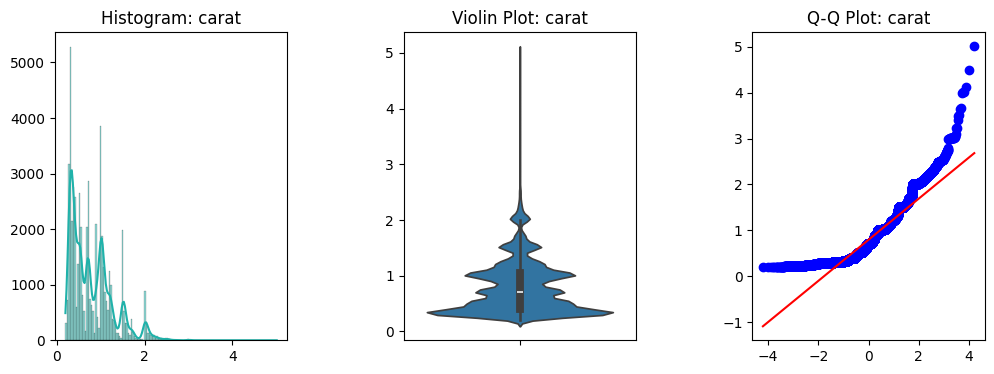

Normal Q-Q fit: R² = 0.89 (Strong fit)


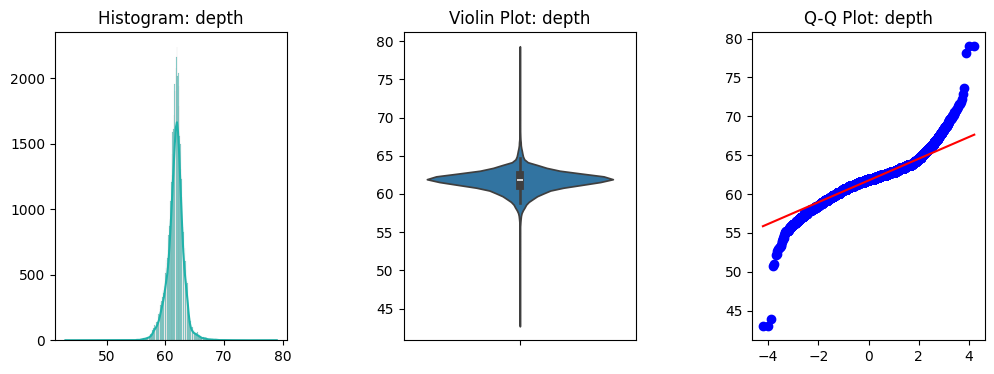

Normal Q-Q fit: R² = 0.95 (Strong fit)


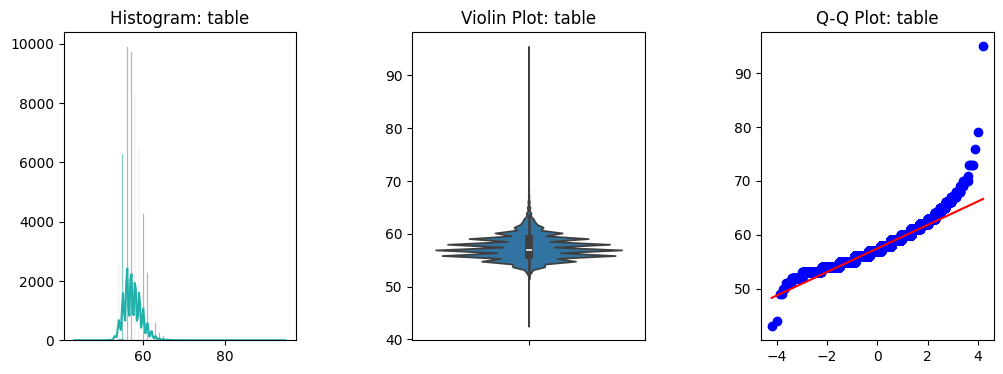

Normal Q-Q fit: R² = 0.95 (Strong fit)


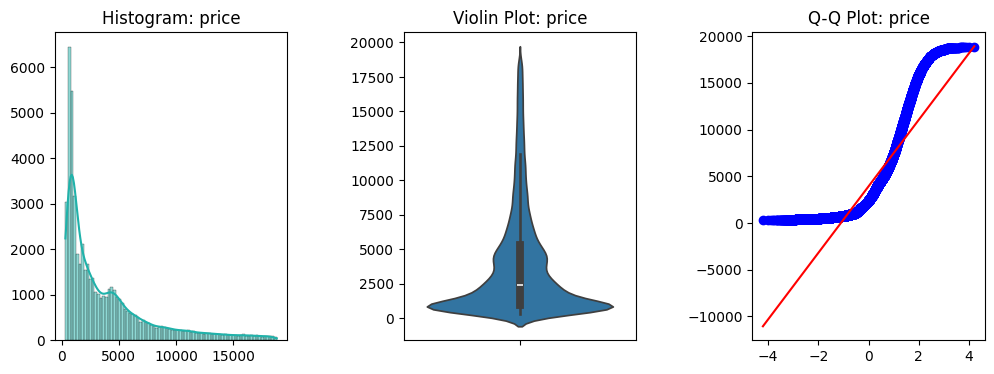

Normal Q-Q fit: R² = 0.8 (Strong fit)


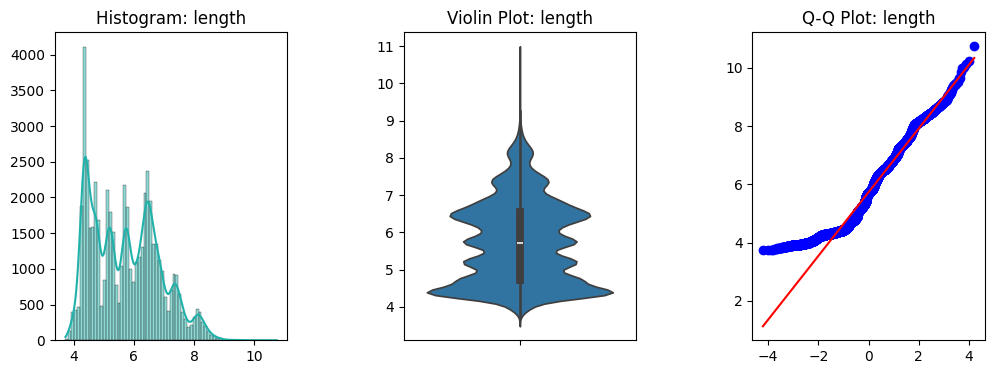

Normal Q-Q fit: R² = 0.96 (Strong fit)


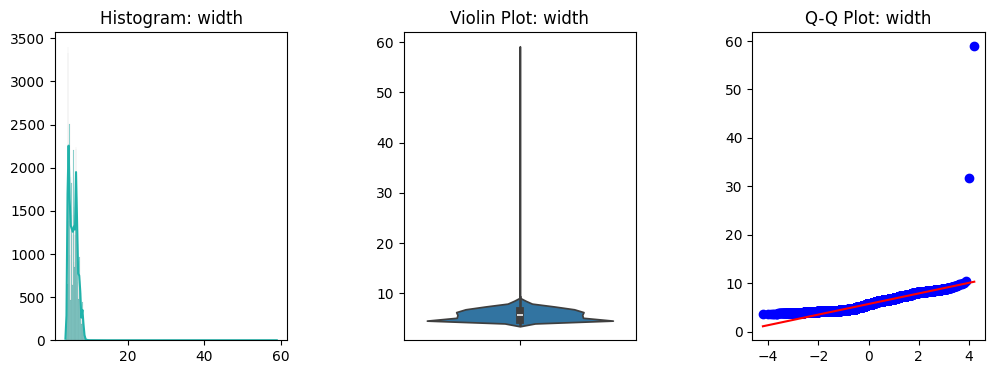

Normal Q-Q fit: R² = 0.92 (Strong fit)


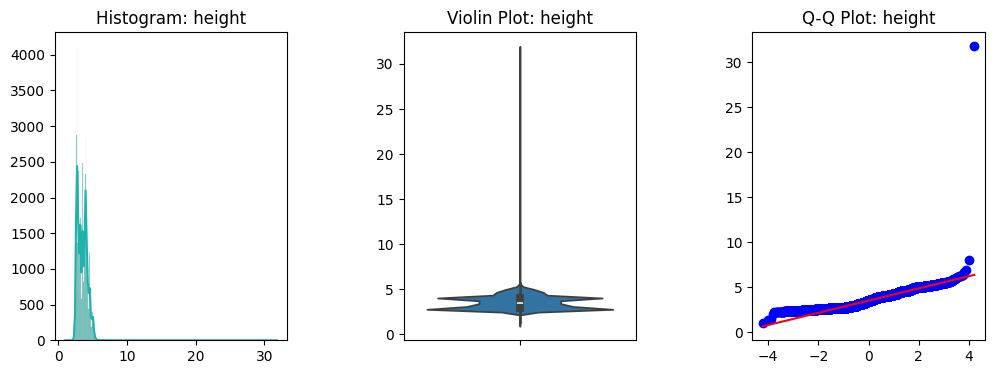

Normal Q-Q fit: R² = 0.93 (Strong fit)


In [ ]:
def plot_numerical_features(dframe, num_feats):
  for feature in num_feats:
          # Create a figure and 3 subplots (1 row, 3 columns)
          fig, axes = plt.subplots(1, 3, figsize=(12, 4))
          plt.subplots_adjust(wspace=0.5)

          # Plot 1: Histogram with kde
          sns.histplot(data=dframe, x=feature, kde=True, ax=axes[0], color='lightseagreen')
          axes[0].set_title(f'Histogram: {feature}')
          axes[0].set_xlabel('')
          axes[0].set_ylabel('')

          # Plot 2: Violin Plot
          sns.violinplot(data=dframe, y=feature, ax=axes[1])
          axes[1].set_title(f'Violin Plot: {feature}')
          axes[1].set_xlabel('')
          axes[1].set_ylabel('')

          # Plot 3: Q-Q Plot
          stats.probplot(dframe[feature], plot=axes[2])
          axes[2].set_title(f'Q-Q Plot: {feature}')
          axes[2].set_xlabel('')
          axes[2].set_ylabel('')
          # Display the plots
          plt.show()
          describe_variation(dframe, feature)

plot_numerical_features(df, numerical_features)

<font size=4, color=#4169E1>💎**OBSERVATIONS**</font>

* Linear models rely on ceratin assumptions(normal residuals, homoscedasticity)we see that most of the features as well as the target `price` violates these assumptions. Therefore, we will have to apply log or Box-Cox transformations to  improve linearity and improve the models overall fit. Also the presence of outliers in the tails can impact the model's accuracy by skewing coefficients or inflating loss. That is where more robust tree-based algorithms like Random Forest or XGBoost come handy as they are better equipped to handle messy data.

### 6.1.2 **Outlier Analysis**

In [ ]:
## For each numerical feature determine the percentage of outliers out of all data points
for feature in numerical_features:
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    percentage_outliers = (len(outliers) / len(df)) * 100
    print(f"Percentage of outliers in {feature}: {percentage_outliers:.2f}%")

Percentage of outliers in carat: 3.49%
Percentage of outliers in depth: 4.72%
Percentage of outliers in table: 1.12%
Percentage of outliers in price: 6.55%
Percentage of outliers in length: 0.04%
Percentage of outliers in width: 0.04%
Percentage of outliers in height: 0.05%


<font size=4, color=#4169E1>💎**OBSERVATIONS**</font>

* `price` (6.55%) and `depth` (4.72%) show the highest outlier rates, indicating potential volatility or measurement inconsistencies. These outliers can distort model coefficients in linear models and inflate error metrics if not addressed.

* `carat` (3.49%) also has a notable outlier presence, likely due to rare high-carat diamonds. These can skew predictions and bias loss functions, especially in parametric models.

* `table` (1.12%)  has a moderate outlier rate, suggesting occasional anomalies but not enough to dominate model behavior.

* `length`, `width`, and `height` (<0.1%) are extremely stable, with negligible outlier influence. These features are well-behaved and unlikely to require aggressive preprocessing.

### **6.1.3 Categorical Features Distributions**

In [ ]:
## Create a list with categorical features
categorical_features =[col for col in df.columns if col not in numerical_features]
print(categorical_features)

['cut', 'color', 'clarity']


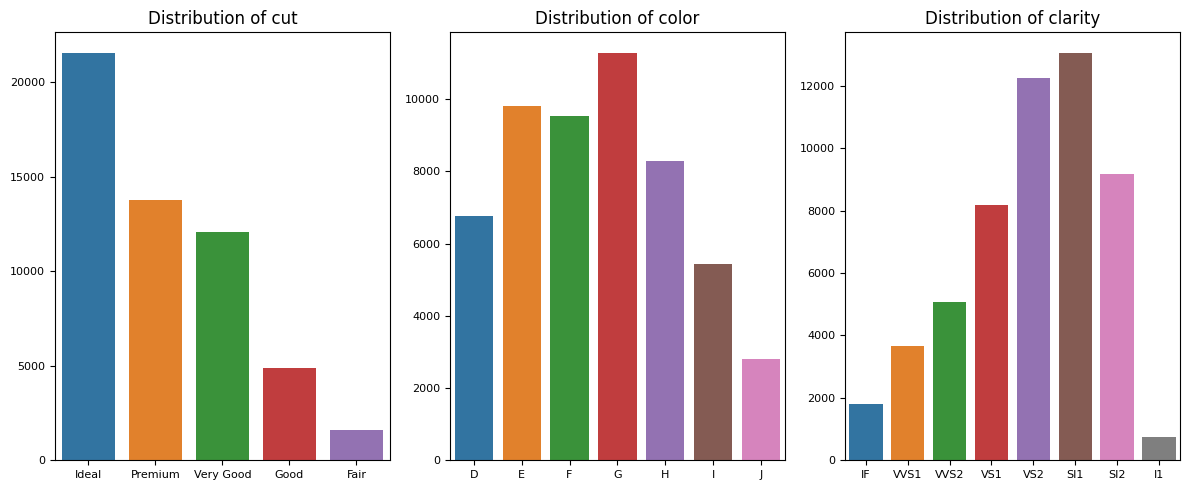

In [ ]:
## Set number of plots per row
plts_per_row = 3

## Calculate required number of rows for subplots
nr_features = len(categorical_features)
rows = (nr_features // plts_per_row) + (nr_features % plts_per_row > 0)

## Create subplot grid with appropriate size
fig, axes = plt.subplots(rows, plts_per_row, figsize=(12, 5 * rows))

## Flatten axes array for easy indexing
axes = axes.flatten()

## Loop through each categorical feature to plot its distribution
for i, feature in enumerate(categorical_features):
  feature_counts = df[feature].value_counts().reset_index()
  feature_counts.columns = [feature, 'count']

  ## Create barplot for the feature
  sns.barplot(x=feature, y='count', data=feature_counts, hue=feature_counts[feature], ax=axes[i])
  axes[i].set_title(f'Distribution of {feature}')
  axes[i].set_xlabel('')
  axes[i].set_ylabel('')

  ## Adjust tick label font sizes
  axes[i].tick_params(axis='x', labelsize=8)
  axes[i].tick_params(axis='y', labelsize=8)

## Remove any unused subplot axes
for j in range(i + 1, len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


<font size=4, color=#4169E1>💎**OBSERVATIONS**</font>

* **Cut**: Most of the diamonds in the dataset are top tier cuts like `Ideal` and `Premium`, which probably reflects what buyers prefer or what sellers tend to stock. That kind of imbalance could shape how a model learns to predict prices, especially if cut plays a big role in determining value.
* **Color**: Most diamonds fall in the near-colorless range (`G`, `E`, `F`), suggesting a sweet spot between quality and affordability. Lower grades (`I`, `J`) are under-represented, which may affect model generalization for cheaper stones.
* **Clarity**: Most of the diamonds in the dataset fall into mid-range clarity grades like `SI1` and `VS2` striking a good balance between price and appearance, making them a popular choice. High-end grades are rare, so models may struggle to predict prices for flawless diamonds due to limited training data.

### **6.1.4 Multiple-factor ANOVA: Categorical Feature Influence on `price`**



ANOVA examines how individual factors/categorical features (`cut`, `color`, and `clarity` affect the single continuous outcome (`price`).

In [ ]:
## Create a copy of the relevant columns to avoid SettingWithCopyWarning
df_anova = df[categorical_features + ['price']].copy()

## Convert categorical variables to categorical dtype using .loc
df_anova.loc[:, 'cut'] = df_anova['cut'].astype('category')
df_anova.loc[:, 'color'] = df_anova['color'].astype('category')
df_anova.loc[:, 'clarity'] = df_anova['clarity'].astype('category')

## Perform ANOVA
model = smf.ols('price ~ cut + color + clarity', data=df_anova).fit()
anova_results = sm.stats.anova_lm(model, typ=2)

anova_results

,sum_sq,df,F,PR(>F)
cut,5.524991e+09,4.0,92.974020,6.163694e-79
color,2.654385e+10,6.0,297.784935,0.000000e+00
clarity,1.998506e+10,7.0,192.175197,9.906918e-283
Residual,8.008276e+11,53905.0,NaN,NaN


In [ ]:
for feat in categorical_features:
  p_val = anova_results.loc[feat, 'PR(>F)']
  if p_val < 0.05:
    print(f"The {feat} feature has a significant impact on diamond price.")
  else:
    print(f"The {feat} feature does not have a significant impact on diamond price.")

The cut feature has a significant impact on diamond price.
The color feature has a significant impact on diamond price.
The clarity feature has a significant impact on diamond price.


<font size=4, color=#4169E1>💎**OBSERVATIONS**</font>


All three factors — `cut`, `color`, `clarity` — have very strong and statistically significant effect on price; we should **keep the predictors**.

* `color` has the largest effect (highest sum_sq and F).
* `clarity` is also very impactful.
* `cut` still matters, but less than the others.

##  <font color=#0000CD>6.2 Bivariate Analysis</font>

### **6.2.1 Price Distribution by Categorical Features**

In [ ]:
def histplot_categorical_feat(feature):
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df, x='price', hue=feature, kde=True, palette='coolwarm')
    plt.title(f'Distribution of Prices by {feature}')
    plt.xlabel('Price')
    plt.ylabel('Count')
    plt.show()


def boxplot_categorical_feat(feature, order):
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='price', y=feature, data=df, showmeans=True, order=order,palette='coolwarm', hue=feature,
                meanprops={"marker":"o","markerfacecolor":"red", "markeredgecolor":"black","markersize":"5"})
    plt.title(f'Boxplot of Diamond prices by {feature}')
    plt.ylabel("")
    plt.show()

#### <font color=#008B8B>6.2.1.1 Distribution of Price by Cut</font>

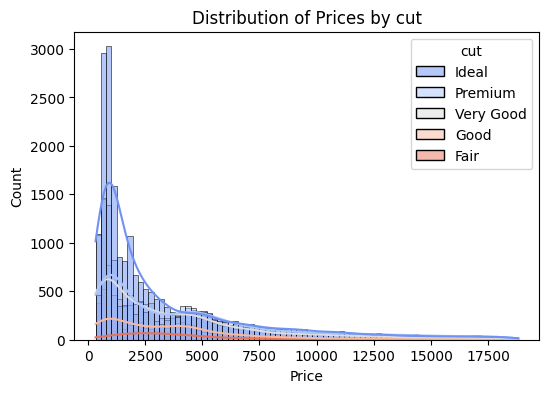

In [ ]:
histplot_categorical_feat('cut')

<font size=4, color=#4169E1>💎**OBSERVATIONS**</font>

* The dataset shows a high volume of `Ideal` and `Premium` cut diamonds, particularly concentrated at lower price points.
* All `cut` grades exhibit heavily right-skewed price distributions, indicating that most diamonds across all cut qualities are found in lower price ranges.
* There is significant overlap in the price distributions across all `cut` grades. This suggests that cut quality alone does not neatly separate diamonds into distinct, isolated price brackets, as diamonds of varying cuts can be found at similar price points.

In [ ]:
print("Descriptive statistics: price for each cut")
df.groupby('cut', observed=False)['price'].describe()

Descriptive statistics: price for each cut


,count,mean,std,min,25%,50%,75%,max
cut,,,,,,,,
Ideal,21548.0,3456.941201,3808.093737,326.0,878.00,1809.5,4678.00,18806.0
Premium,13782.0,4579.419896,4343.646613,326.0,1046.00,3181.0,6290.00,18823.0
Very Good,12082.0,3981.562738,3935.863847,336.0,912.00,2648.0,5372.75,18818.0
Good,4902.0,3926.403509,3676.772435,327.0,1144.25,3050.5,5028.00,18707.0
Fair,1609.0,4357.500932,3561.136245,337.0,2050.00,3282.0,5198.00,18574.0


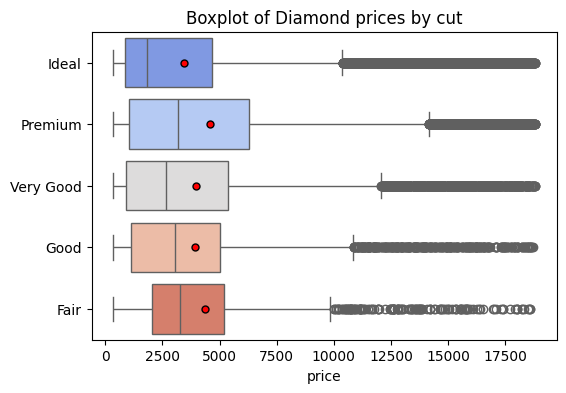

In [ ]:
boxplot_categorical_feat('cut', cut_order)

<font color=red> The red dots represent the mean price for each cut grade.</font>

<font size=4, color=#4169E1>💎**OBSERVATIONS**</font>

Despite being the top cut grade, `Ideal` diamonds often have lower absolute prices than `Premium` or even `Fair` cuts. This counterintuitive trend stems from the carat weight effect: higher-quality cuts tend to appear in smaller stones, which lowers their total price, whereas larger diamonds with lower cut grades command higher prices simply due to size. The data highlights how cut quality and size interact in complex ways, making it clear that no single factor determines value in isolation.

#### <font color=#008B8B>6.2.1.2 Distribution of Price by Color</font>





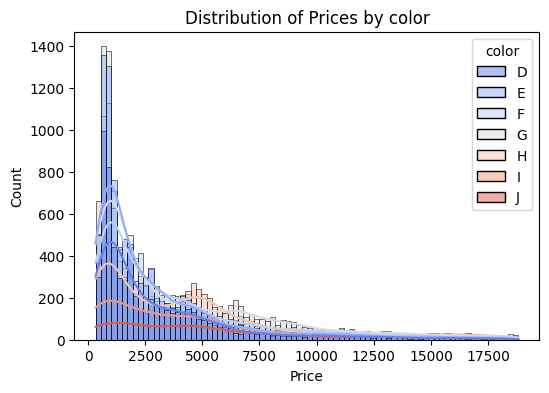

In [ ]:
histplot_categorical_feat('color')

<font size=4, color=#4169E1>💎**OBSERVATIONS**</font>

* Most diamonds are priced below 5000, with a significant concentration of diamonds priced between 0 and 2500.

* The distributions are all right-skewed, indicating that higher-priced diamonds are less common.

* Diamond prices span a wide range across all color grades with plenty of overlap. No single grade is locked into a specific price bracket. We will find diamonds of every color at both the low and high ends of the price spectrum, just with different levels of frequency.

* Diamonds with higher color quality appear more frequently in the lower price ranges, which suggests that many of them are smaller in size and therefore more affordable despite their excellent color grade.

In [ ]:
print("Descriptive statistics: price for each color")
df.groupby('color', observed=False)['price'].describe()

Descriptive statistics: price for each color


,count,mean,std,min,25%,50%,75%,max
color,,,,,,,,
D,6774.0,3168.106436,3353.391411,357.0,911.0,1836.5,4212.5,18693.0
E,9799.0,3076.687111,3343.820487,326.0,882.5,1739.0,4001.5,18731.0
F,9539.0,3724.978614,3785.508665,342.0,982.0,2344.0,4867.5,18791.0
G,11284.0,3996.876551,4049.165898,354.0,931.0,2240.0,6048.0,18818.0
H,8298.0,4480.942155,4208.831366,337.0,984.0,3453.5,5975.0,18803.0
I,5421.0,5089.973990,4720.748071,334.0,1120.0,3730.0,7186.0,18823.0
J,2808.0,5323.818020,4438.187251,335.0,1860.5,4234.0,7695.0,18710.0


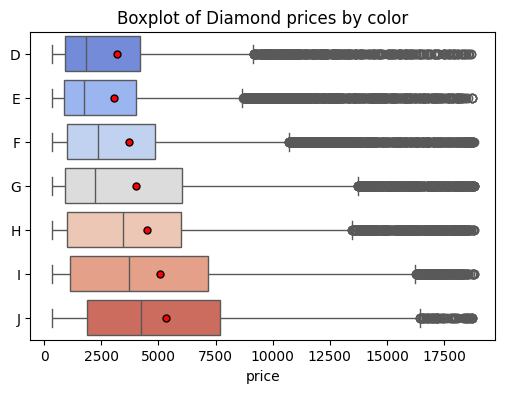

In [ ]:
boxplot_categorical_feat('color', color_order)

<font size=4, color=#4169E1>💎**OBSERVATIONS**</font>

We observe a counterintuitive trend: diamonds with lower color grades (`J`) tend to have higher average prices than those with higher grades (`D`), likely because color is inversely related to carat weight. Smaller, high-quality diamonds cost less overall, while larger, lower-grade ones drive up the price.

#### <font color=#008B8B>6.2.1.3  Distribution of Price by Clarity</font>


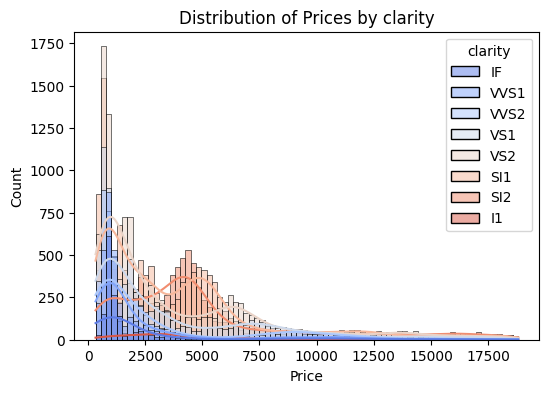

In [ ]:
histplot_categorical_feat('clarity')

<font size=4, color=#4169E1>💎**OBSERVATIONS**</font>
* `SI1` and` VS2 `are the most abundant clarity grades overall.
* The price distribution for every clarity grade is heavily right-skewed. The vast majority of diamonds in each clarity category are concentrated at lower price points.
* The price distributions for all clarity grades extensively overlap. There are no distinct price ranges exclusive to a particular clarity grade.
* Diamonds with lower clarity grades tend to show up more often among the higher-priced stones, which tells us that many of these expensive diamonds are actually large but not perfectly clear. Their size pushes the price up, even if their clarity is not top-notch.


In [ ]:
print("Descriptive statistics: price for each clarity level")
df.groupby('clarity', observed=False)['price'].describe().reset_index()

Descriptive statistics: price for each clarity level


,clarity,count,mean,std,min,25%,50%,75%,max
0,IF,1790.0,2864.839106,3920.248499,369.0,895.00,1080.0,2388.50,18806.0
1,VVS1,3654.0,2519.512315,3328.175459,336.0,816.00,1092.5,2376.00,18777.0
2,VVS2,5066.0,3283.737071,3821.647537,336.0,794.25,1311.0,3638.25,18768.0
3,VS1,8170.0,3839.144308,4011.894939,327.0,876.00,2005.0,6021.00,18795.0
4,VS2,12255.0,3922.771685,4039.914100,334.0,900.00,2052.0,6022.50,18823.0
5,SI1,13065.0,3993.923077,3796.430128,326.0,1089.00,2822.0,5249.00,18818.0
6,SI2,9185.0,5060.440174,4256.944654,326.0,2264.00,4072.0,5775.00,18804.0
7,I1,738.0,3926.189702,2811.615917,345.0,2071.00,3346.0,5167.75,18531.0


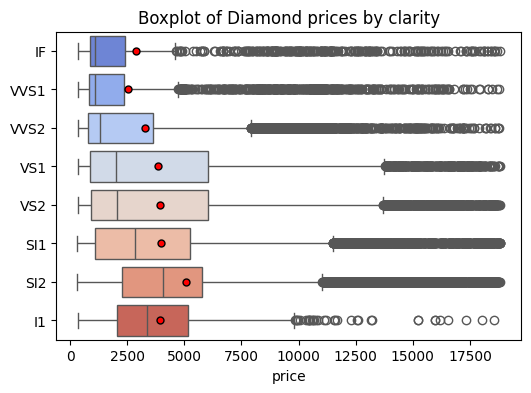

In [ ]:
boxplot_categorical_feat('clarity', clarity_order)

<font size=4, color=#4169E1>💎**OBSERVATIONS**</font>

Surprisingly, diamonds with the highest clarity grades like `IF` and `VVS1 ` actually show lower average prices than those with mid to lower clarity grades such as `SI1` and `SI2`, with `SI2` coming out on top. This pattern suggests that `carat` weight plays a big role suggesting that  top clarity diamonds tend to be smaller, which keeps their total price down. Across all clarity levels, prices vary widely and even diamonds with less than perfect clarity can be worth a lot if they are  big enough.

<font color=purple>In this dataset, we can infer that carat weight has a stronger influence on price than the other diamond attributes (`cut`, `color` or `clarity`).</font>


### **6.2.2 Impact of Carat on Price**

To precisely understand the direct quantitative relationship, we visualize how the average diamond price changes across different carat weights.

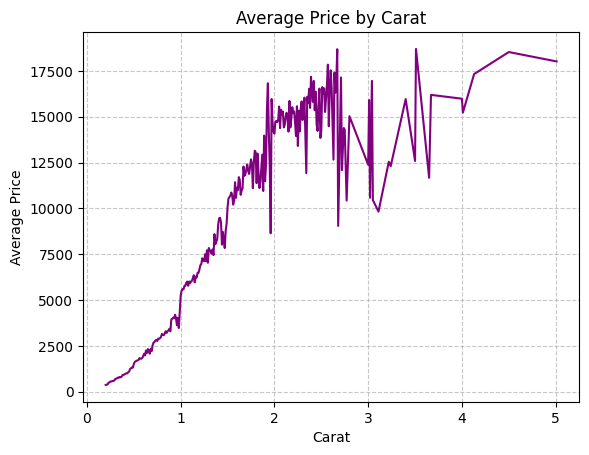

In [ ]:
## Calculate average price for each carat value
carat_price = df.groupby('carat')['price'].mean().reset_index()

## Plot the average price against carat using a line plot
sns.lineplot(data=carat_price, x='carat', y='price', color='purple')
plt.title('Average Price by Carat')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Carat')
plt.ylabel('Average Price')
plt.show()

<font size=4, color=#4169E1>💎**OBSERVATIONS**

There is a  very clear and strong positive relationship between `carat `and average `price`. As carat weight increases, the average price generally rises significantly.

 We  can therefore  reason that diamonds with higher quality grades in `cut`, `color`, and `clarity` tend to have lower average prices when their `carat` size is smaller. In other words, top-tier diamonds often cost less in absolute terms simply because they are smaller. This pattern suggests that `carat` is a dominant feature in pricing and interacts inversely with the other quality attributes, leading to some counterintuitive trends in the data.

### **6.2.3 Evaluating Categorical Feature Dependencies**

To understand how different categorical features in the diamond dataset relate to each other, we started by running Chi-squared tests of independence. These tests help determine whether two categorical variables are statistically connected or behave independently.

When the p-value is below 0.05, it signals a meaningful association between the variables. But knowing that a relationship exists is not enough, we also want to know how strong it is. That's where Cramér's V comes in: it quantifies the strength of the association, helping us decide whether certain features might be redundant or worth keeping in the model.

#### <font color=#008B8B>6.2.3.1 Chi-square : Is their a relationship?

In [ ]:
#categorical_features

In [ ]:
## Loop through all unique pairs of categorical features
for var1, var2 in combinations(categorical_features, 2):

    ## Create a contingency table for the two variables
    contingency_table = pd.crosstab(df[var1], df[var2])

    ## Perform the Chi-square test of independence
    chi2_stat, p_val, _, _ = chi2_contingency(contingency_table)
    print(f"Chi-square test between {var1} and {var2}: Chi2 Stat = {chi2_stat:.2f}, P-value = {p_val:.4f}")

    ## Interpret the result based on significance level (0.05)
    if p_val < 0.05:
        print(f"{var1.capitalize()} and {var2} are associated.\n")
    else:
        print(f"{var1.capitalize()} and {var2} are not associated.\n")


Chi-square test between cut and color: Chi2 Stat = 309.66, P-value = 0.0000
Cut and color are associated.

Chi-square test between cut and clarity: Chi2 Stat = 4396.08, P-value = 0.0000
Cut and clarity are associated.

Chi-square test between color and clarity: Chi2 Stat = 2048.85, P-value = 0.0000
Color and clarity are associated.



#### <font color=#008B8B>6.2.3.2 Cramér's V : How strong is that relationship?





In [ ]:
def cramers_v(x, y):
    """Calculate Cramér's V statistic for categorical-categorical association."""

    ## Create a contingency table between the two categorical variables
    confusion_matrix = pd.crosstab(x, y)

    ## Perform Chi-square test on the contingency table
    chi2, _, _, _ = chi2_contingency(confusion_matrix)

    ## Total number of observations
    n = confusion_matrix.sum().sum()

    ## Compute raw phi-squared value
    phi2 = chi2 / n

    ## Get number of rows and columns in the contingency table
    r, k = confusion_matrix.shape

    ## Apply bias correction to phi-squared
    phi2_corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1))

    ## Corrected row and column counts
    r_corr = r - ((r - 1)**2) / (n - 1)
    k_corr = k - ((k - 1)**2) / (n - 1)

    ## Calculate Cramér's V with bias correction
    v = np.sqrt(phi2_corr / min((k_corr - 1), (r_corr - 1)))

    return v

def interpret_strength(v):
    """Return strength label based on Cramér's V value."""

    ## Categorize the strength of association based on thresholds
    if v < 0.10:
        return "Negligible"
    elif v < 0.30:
        return "Weak"
    elif v < 0.50:
        return "Moderate"
    else:
        return "Strong"

## Define the list of categorical features to analyze
categorical_features = ['cut', 'color', 'clarity']

## Loop through all unique pairs of categorical features
for var1, var2 in combinations(categorical_features, 2):

    ## Compute Cramér's V for the pair
    v = cramers_v(df[var1], df[var2])

    ## Interpret the strength of the association
    strength = interpret_strength(v)

    ##Print the result with formatted output
    print(f"Cramér’s V between {var1} and {var2}: {v:.4f} → {strength} association")


Cramér’s V between cut and color: 0.0364 → Negligible association
Cramér’s V between cut and clarity: 0.1423 → Weak association
Cramér’s V between color and clarity: 0.0788 → Negligible association


<font size=4, color=#4169E1>💎**OBSERVATIONS**</font>

Chi-squared tests revealed statistically significant associations between all pairs of categorical features: cut, color, and clarity. This means the distribution of one variable tends to vary depending on the other.

However, when we looked at the strength of these associations using Cramér's V, the relationships were found to be negligible to weak. This suggests that while the features are not entirely independent, they do not overlap enough to cause concern for multicollinearity.

Each feature contributes mostly unique information, and there is no need to drop or combine them based on redundancy.


### **6.2.4 Exploring Price Patterns Across Categorical Feature Interactions**






To uncover how diamond quality attributes affect pricing, we normalize the `price` by `carat` weight using `price_per_carat`.

This transformation allows us to examine how the categorical features such as `cut`, `color`, and `clarity` interact and influence pricing. By removing the direct scaling effect of carat, we neutralize the size effect, allowing us to see how quality alone affects value.

In [ ]:
categorical_features

['cut', 'color', 'clarity']

In [ ]:
df['price_per_carat'] = df['price'] / df['carat']

#### <font color=#008B8B>6.2.4.1 Price-per-Carat  vs Cut and Color




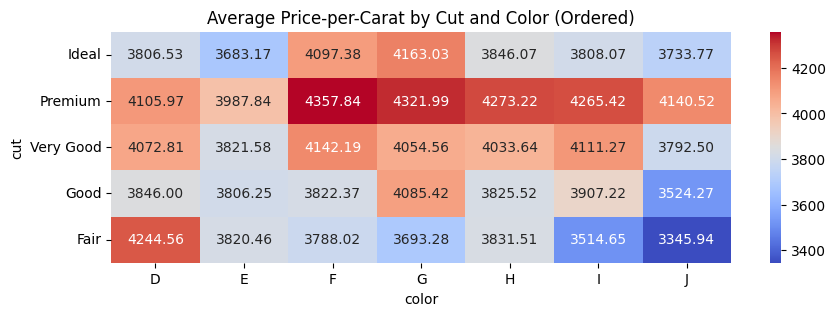

In [ ]:
## Create a pivot table showing average price-per-carat by cut and color
ppc_pivot_cut_col = pd.pivot_table(
    df,
    values='price_per_carat',
    index='cut',
    columns='color',
    aggfunc='mean',
    observed=False  # Include all combinations even if not observed
)

## Set figure size for the heatmap
plt.figure(figsize=(10, 3))

## Plot the pivot table as a heatmap with annotations and color gradient
sns.heatmap(ppc_pivot_cut_col, annot=True, cmap='coolwarm', fmt='.2f')

## Add a descriptive title
plt.title("Average Price-per-Carat by Cut and Color (Ordered)")

## Display the heatmap
plt.show()

#### <font color=#008B8B>6.2.4.2 Price-per-Carat  vs Cut and Clarity

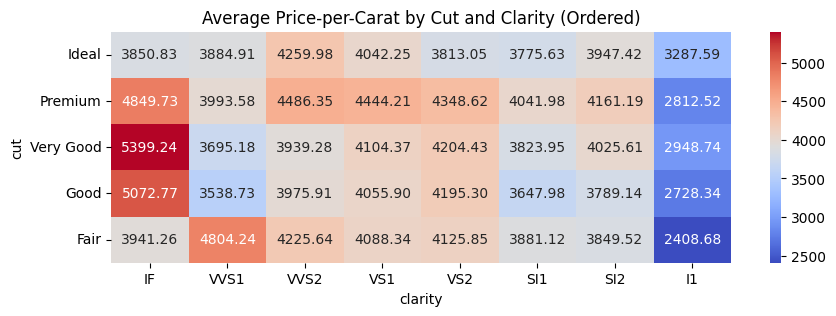

In [ ]:
ppc_pivot_cut_clar = pd.pivot_table(df, values='price_per_carat', index='cut', columns='clarity', aggfunc='mean', observed=False)
plt.figure(figsize=(10, 3))
sns.heatmap(ppc_pivot_cut_clar, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Average Price-per-Carat by Cut and Clarity (Ordered)")
plt.show()

#### <font color=#008B8B>6.2.4.3 Price-per-Carat  vs Color and Clarity









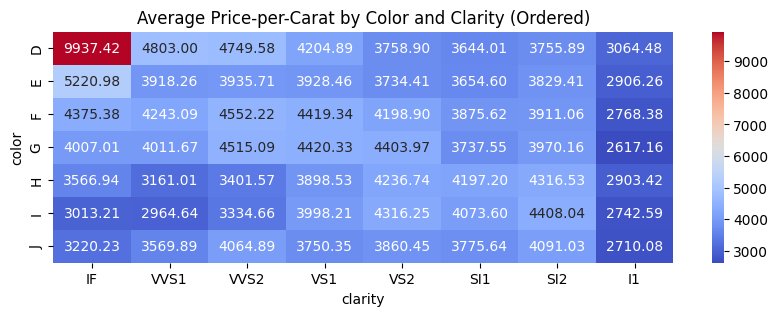

In [ ]:
ppc_pivot_col_clar = pd.pivot_table(df, values='price_per_carat', index='color', columns='clarity', aggfunc='mean', observed=False)
plt.figure(figsize=(10, 3))
sns.heatmap(ppc_pivot_col_clar, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Average Price-per-Carat by Color and Clarity (Ordered)")
plt.show()

<font size=4, color=#4169E1>💎**OBSERVATIONS**</font>

*  The way the features influence price is not simply additive, we have to look at the their interaction to understand the true `price-per-carat`.
*  We must include interaction terms (e.g., `cut` * `color`) if we want our model to capture these real-world pricing dynamics. A linear model without interaction terms assumes an additive relationship, which would lead to less accurate predictions.
* Tree-based models  are often superior for such problems as they can inherently capture the interaction.

* While `cut`, color, and `clarity` follow a natural order, assigning them simple numeric values like `Ideal` as 5 or `Premium` as 4 suggests a direct, linear relationship with price. But the `price_per_carat` heatmaps tell a different story. They reveal complex, non-linear patterns. For example, `Premium` often ends up more expensive than `Ideal` within certain color ranges. This clearly shows that basic ordinal encoding oversimplifies the reality and can lead to misleading results.
  * Therefore, to accurately capture these nuanced and non-linear relationships, we must use alternative encoding strategies like **One-Hot Encoding** or **Target Encoding**. We choose Target Encoding because it transforms each categorical feature into a single informative value, which reduces dimensionality and provides a strong signal that tree based models can use effectively.

* The heatmaps provides a baseline understanding that can be used to explain why a model might predict a certain price for a given quality attribute pairing. For example, if a model predicts a low price for a 'Fair' cut, 'J' color diamond, this heatmap confirms that this is an expected outcome.


## <font color=#0000CD>6.3 Multivariate Analysis

### **6.3.1 Correlation Analysis**

Here, we are taking a closer look at how the numerical features relate to each other and more importantly, how each one connects to the target variable, `price`. We want to spot patterns, understand which features move together, and figure out which ones might actually help us predict `price` more effectively.

#### <font color=#008B8B>6.3.1.1 Correlation Matrix

The correlation matrix highlights how each feature is linearly related to the others, including their connection to the target variable.

<font color=red>**Anything below or equal to 0.03 can be ignored very close to 0.**</font>

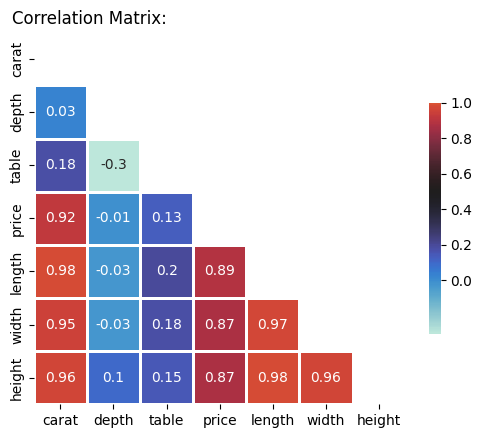

In [ ]:
corr_matrix = df[numerical_features].corr().round(2)
# Generate a mask to the upper triangle of the matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(6, 6))
# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(corr_matrix, mask=mask,  vmax=1, center=0.5,
                 square=True, linewidths=0.8,
                 cbar_kws={"shrink": .5, 'ticks':[0, 0.2, 0.4, 0.6, 0.8, 1]}, annot=True)
plt.title("Correlation Matrix:", x=0.15)
plt.show()

<font size=4, color=#4169E1>💎**OBSERVATIONS**</font>

**How predictors relate to `price`**

* The features `carat`, `length`, `width`, and `height` stand out as strong indicators of diamond `price`. These are the ones we will want to focus on whereas `table` has minimal impact and `depth` has negligible impact.

* Dropping `depth` will lead to slightly more efficient and faster training and a cleaner model without sacrificing any predictive performance, as it carries no useful information for predicting price.

* `carat`, `length`, `width`, and `height` are closely tied together(overlap). This is to be expected as all these features describe the size of the diamond. This overlap(multicollinearity) can complicate interpretation as it is harder to determine their individual influence on `price`.

* Tree-based models are great at handling overlap between features. Even if some predictors are correlated, the model will sort out which ones matter most.

In [ ]:
## Drop 'depth' from the data
df_without_depth = df.drop(columns=['depth'])
numerical_features.remove('depth')

#### <font color=#008B8B>6.3.1.2 Pair Plot Visualization</font>

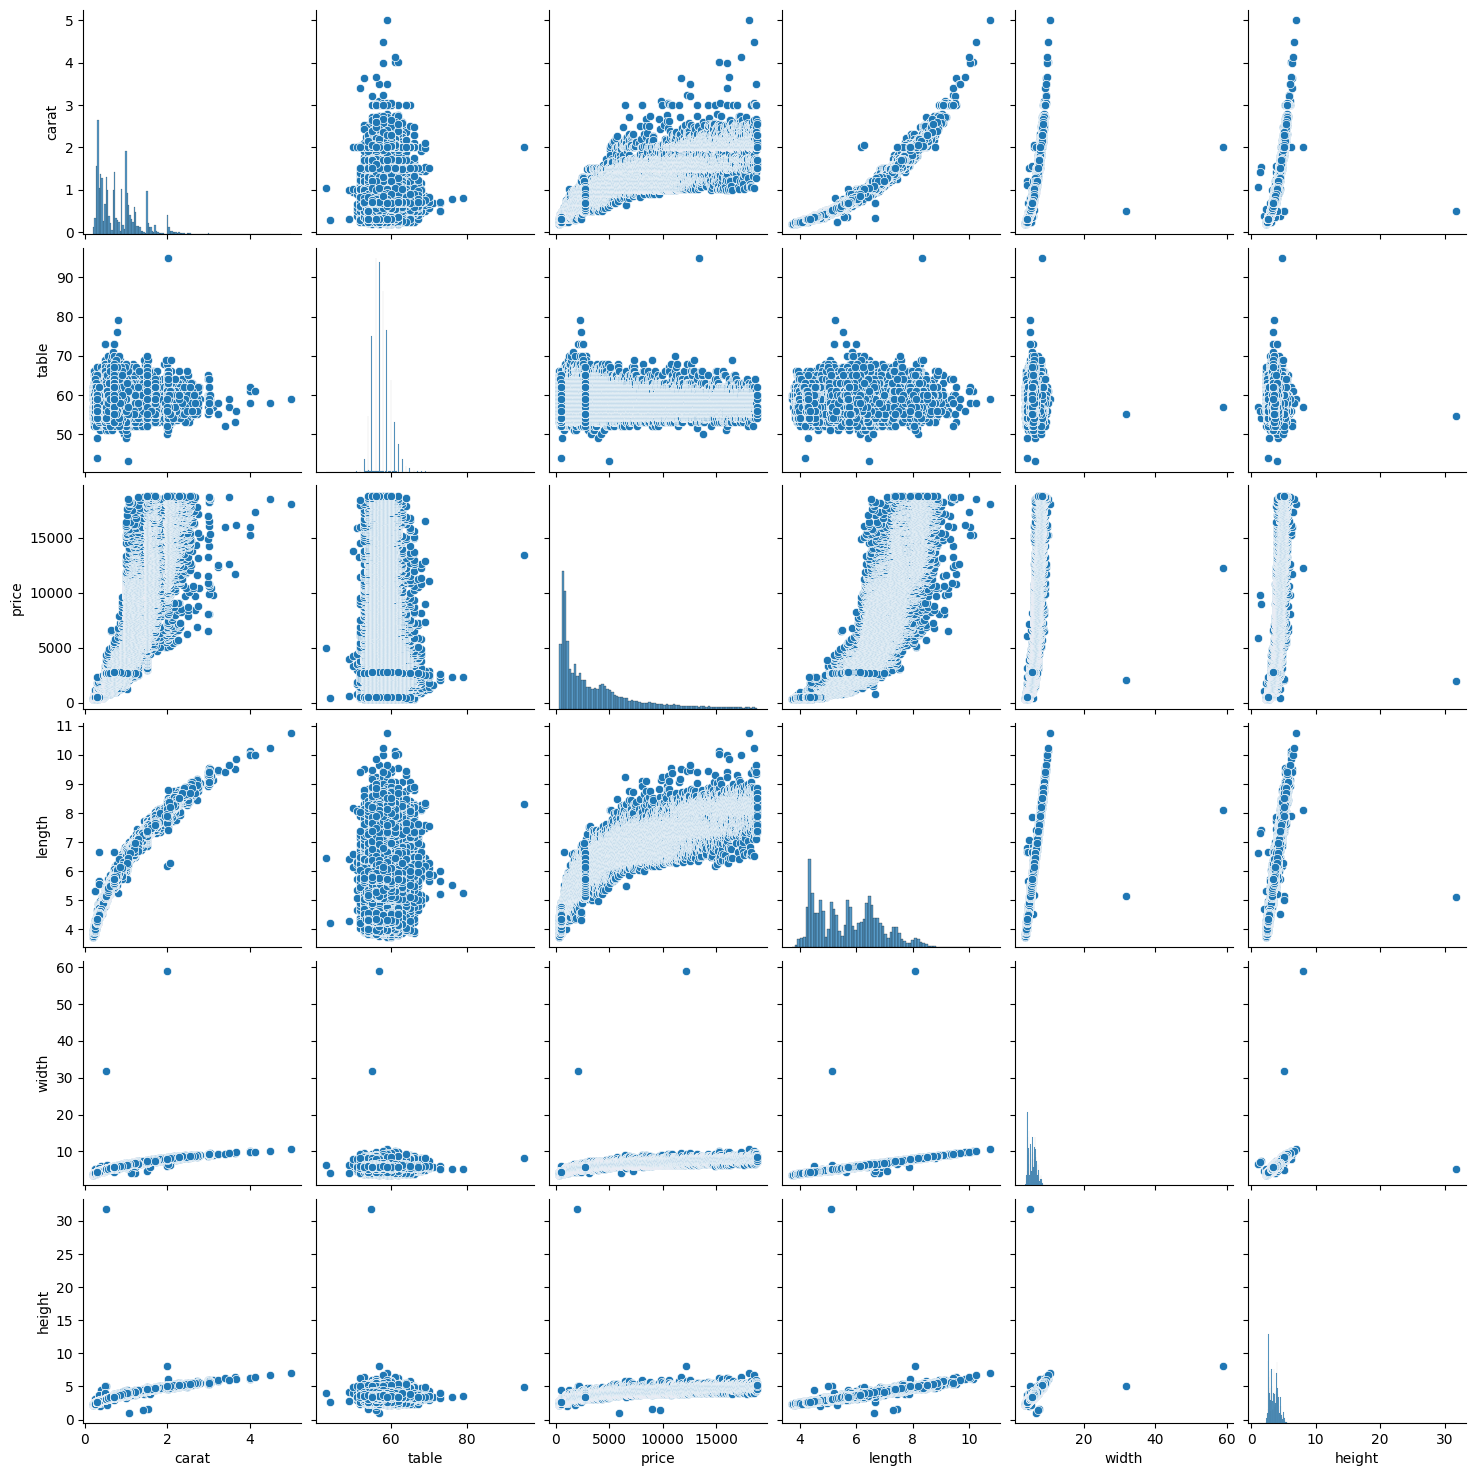

In [ ]:
# Pair plot of selected continuous variables
sns.pairplot(df_without_depth[numerical_features])
plt.show()

<font size=4, color=#4169E1>💎**OBSERVATIONS**</font>

* Across the dataset, `carat` stands out as the strongest predictor of `price`, showing a clear positive relationship and strong ties to physical dimensions like `length`, `width`, and `height`. These size-related features are tightly interlinked, suggesting multicollinearity(especially relevant for linear models), though tree-based models handle it well.
* `table` shows weak or negligible relationships with both `price` and other predictors, making it a good candidate for exclusion in a streamlined model.

* Generally, `price` tends to rise with `carat` and physical size; however, due to dimensional overlap, strategic feature selection is essential for optimizing both model accuracy and interpretability.

#<u><font color=#000080>7. Data Preprocessing

## <font color=#0000CD>7.1 Splitting Data into Training and Test Sets




In [ ]:
## Define feature matrix X
X = df_without_depth.drop(columns=['price', 'price_per_carat'])

## Define target variable y as the original price column
y = df_without_depth['price']

In [ ]:
## Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
## Define num_features
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [ ]:
X_train_t = X_train.copy()
X_test_t = X_test.copy()

y_train_t = y_train.values.ravel().copy()
y_test_t = y_test.values.ravel().copy()

### **7.2.1 Apply Log Transformations to Skewed Numerical Features + Target**









Applying log transformations to the numerical features help normalize their skewed distributions and linearize relationships. We also log-transform the target variable `price` to align its distribution with model assumptions as required by linear models.

In [ ]:
## Log-transform right-skewed numerical features
X_train_t[num_features] = np.log1p(X_train_t[num_features])

## Apply same transformation to X_test using same logic
X_test_t[num_features] = np.log1p(X_test_t[num_features])

## Visualize distributions
#plot_numerical_features(X_train_t, num_features)

## Log-transform target variable
y_train_t = np.log1p(y_train_t)
y_test_t = np.log1p(y_test_t)

#plot_numerical_features(y_train_t, ['price'])

### **7.2.3 Encode Categorical Features**

#### <font color=#008B8B>7.2.3.1 Target Encoding</font>




Target encoding converts categorical features into numerical representations that directly reflect their relationship with the target variable (on the log scale).

While `cut`, `color`, and `clarity` possess a clear inherent order based on quality, our exploratory data analysis (particularly the `price_per_carat` heatmaps) revealed that their relationship with  `price` is far from simple or strictly monotonic. We observed complex interactions where, for instance, certain "lower" quality grades (like `Premium` cut or `J` color) sometimes corresponded to higher `price_per_carat` values depending on other attributes like `carat`.

Directly applying ordinal encoding (assigning numerical ranks like 1, 2, 3...) to these features would force our models, especially linear ones, to assume a rigid, additive, and monotonic relationship with `price`, which our data clearly contradicts. This could lead to less accurate predictions and misrepresentation of these features' true impact.

Instead, we implement Target Encoding, which replaces each category with the actual mean of the target variable (log(`price`)), grounding the encoding in real data patterns. This approach captures how each category genuinely influences the outcome, based on observed behavior rather than arbitrary assignment. Because these averages are influenced by how other features behave in the data, the encoding naturally picks up on deeper patterns and relationships

Compared to one-hot encoding, it also reduces dimensionality, improving model efficiency.

In [ ]:
## Reset index for X_train_t and X_test_t to align with y_train_log
X_train_t = X_train_t.reset_index(drop=True)
X_test_t = X_test_t.reset_index(drop=True)

## Apply Target Encoding
encoder = TargetEncoder(cols=categorical_features)
##  Fit encoder on training data only
X_train_encoded = encoder.fit_transform(X_train_t[categorical_features], y_train_t)
## Apply fitted encoder to test data
X_test_encoded = encoder.transform(X_test_t[categorical_features])

## Combine with other features
X_train_all = pd.concat([X_train_encoded, X_train_t.drop(columns=categorical_features)], axis=1)
X_test_all = pd.concat([X_test_encoded, X_test_t.drop(columns=categorical_features)], axis=1)

## **7.3 Standardize Features**





To ensure that all features contribute equally to the model and avoid bias from differing scales, we apply standardization using StandardScaler. This transformation centers each feature around zero with unit variance which is especially important for models sensitive to feature magnitude (e.g., linear regression, SVM). The scaler is fit on the training data only to prevent leakage, then applied to the test set. Finally, we convert the scaled arrays back to DataFrames for seamless integration with downstream tasks.

In [ ]:
scaler = StandardScaler()

## Fit the scaler on training data and transform it
X_train_p_arr = scaler.fit_transform(X_train_all)

## Apply the same transformation to the test data using the fitted scaler
X_test_p_arr = scaler.transform(X_test_all)

# Convert the numpy arrays back to DataFrame for easier handling
X_train_p = pd.DataFrame(X_train_p_arr, columns=X_train_t.columns)
X_test_p = pd.DataFrame(X_test_p_arr, columns=X_test_t.columns)

## Preserve the log-transformed target variables for modeling
y_train_p = y_train_t.copy()
y_test_p = y_test_t.copy()

#<u><font color=#000080>8. Model Building & Evaluation

In [ ]:
## Create a new empty dataframe
model_comparison_df = pd.DataFrame(columns=['Model', 'RMSE(train)', 'RMSE(test)', 'RMSE (gap_pct)','RMSE(test) / Mean Price', 'R²(train)',  'R²(test)'])
model_comparison_df = None # Initialize as None

In [ ]:
 from sklearn.metrics import median_absolute_error

def evaluate_model(model_name, model, X_train_m, X_test_m, y_train_m, y_test_m):
    ## Make predictions in Log scale (y_train is log-transformed)
    y_pred_log_train = model.predict(X_train_m)
    y_pred_log_test = model.predict(X_test_m)

    ## Convert predictions back to original scale
    y_pred_train_orig = np.expm1(y_pred_log_train)
    y_pred_test_orig = np.expm1(y_pred_log_test)

    ## Convert actual target values back to original scale
    y_train_orig = np.expm1(y_train_m)
    y_test_orig = np.expm1(y_test_m)

    ## Evaluate the  model
    rmse_train = np.sqrt(mean_squared_error(y_train_orig, y_pred_train_orig))
    rmse_test = np.sqrt(mean_squared_error(y_test_orig, y_pred_test_orig))



    ## Calculate Median Absolute Error
    medae_test = median_absolute_error(y_test_orig, y_pred_test_orig)


    mean_price = y_test_orig.mean().item()
    rmse_mean_pct = (rmse_test / mean_price) * 100

    # R² is most accurate on the log-transformed model
    r2_train_log = r2_score(y_train_m, y_pred_log_train)
    r2_test_log = r2_score(y_test_m, y_pred_log_test)



    ## Append to model_comparison_df using pd.concat
    data = {'Model': model_name,
            'RMSE(train)': round(rmse_train, 2),
            'RMSE(test)': round(rmse_test, 2),
            'RMSE (gap_pct)' :  round((rmse_test - rmse_train) / rmse_train * 100,2),
            'RMSE(test) / Mean Price (pct)': round(rmse_mean_pct, 2),  # how large the model's prediction errors are relative to the typical price of a diamond
            'MedAE(test)' : round(medae_test, 2),
            'R²(train)(log)': round(r2_train_log, 2),
            'R²(test)(log)': round(r2_test_log, 2)}

    global model_comparison_df  # Ensure the DataFrame is accessible within the function
    new_row_df = pd.DataFrame([data])

    if model_comparison_df is None:
        model_comparison_df = new_row_df
    else:
        model_comparison_df = pd.concat([model_comparison_df, new_row_df], ignore_index=True)

## <font color=#0000CD>8.1 Baseline Model : Linear Regression

In [ ]:
X_train_lr = X_train_p.copy()
X_test_lr = X_test_p.copy()

y_train_lr = y_train_p.copy()
y_test_lr = y_test_p.copy()

Train and evaluate a baseline Linear Regression model to set the benchmark.

In [ ]:
## Build a linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train_lr, y_train_lr)

evaluate_model('Baseline Model: Linear Regression', lr_model, X_train_lr, X_test_lr, y_train_lr, y_test_lr)
model_comparison_df

,Model,RMSE(train),RMSE(test),RMSE (gap_pct),RMSE(test) / Mean Price (pct),MedAE(test),R²(train)(log),R²(test)(log)
0,Baseline Model: Linear Regression,1207.51,1079.45,-10.61,27.4,201.43,0.97,0.97


<font size=4, color=#4169E1>💎**OBSERVATIONS**</font>

* A negative RMSE gap of -10.61%, indicating that the test RMSE is lower than the training RMSE, reflects strong generalization to unseen data and no evidence of overfitting.
* A 27.4% error relative to the mean price signifies that while the model has learned the overall trends, there's still a significant portion of the actual price variation it's not capturing with high precision in real dollar terms. This indicates room for improvement, which you then achieve with your more advanced models.
* About half of the model's predictions are within \$201.43 of the actual diamond price. That's a pretty small error for most diamonds, but when it comes to very low-priced stones, even a $200 difference can be a big deal. This means the model is less precise at the cheaper end of the spectrum.

* The model exhibits a high R² of 0.97 for both training and test sets on the log-transformed price, indicating it effectively captures a significant portion of the variance in the transformed scale.


### **8.1.1.Feature Importance for Linear Regression**

* A positive coefficient means as the feature increases, the price increases.
* A negative coefficient means as the feature increases, the price decreases.

In [ ]:
## Get the coefficients and reshape to ensure they are 1-dimensional
lr_coefficients = lr_model.coef_.ravel()

## Create a DataFrame to display the feature importance
feature_importance_lr = pd.DataFrame({
    'Feature': X_train_lr.columns,
    'Coefficient': lr_coefficients
})

## Sort the features by the absolute value of the coefficients
feature_importance_lr['Absolute Coefficient'] = feature_importance_lr['Coefficient'].abs()
feature_importance_lr = feature_importance_lr.sort_values(by='Absolute Coefficient', ascending=False)

#print(feature_importance_lr)
feature_importance_lr

,Feature,Coefficient,Absolute Coefficient
5,length,0.833949,0.833949
7,height,0.249804,0.249804
2,color,-0.186536,0.186536
1,cut,-0.129082,0.129082
0,carat,-0.022288,0.022288
6,width,0.011093,0.011093
3,clarity,-0.001981,0.001981
4,table,-0.000292,0.000292


<font size=4, color=#4169E1>💎**OBSERVATIONS**</font>

* `length` and `height` are identified as the primary positive drivers of diamond `price`. This is highly intuitive, as these features directly relate to the overall size of the diamond. `width` also shows a very small positive impact.This confirms that, as expected, larger diamonds generally command higher prices.


* The coefficient analysis offers some useful takeaways, but <font color=firebrick>the negative sign for `carat `stands out as a clear red flag.</font> Since `carat` is typically a strong positive driver of diamond prices, this result doesn't make logical sense and points to multicollinearity possibly skewing the model's interpretability. This necessitates further investigation, such as Variance Inflation Factor (VIF) analysis and potential feature engineering, to improve the stability and interpretability of the  linear model, which will be addressed in subsequent steps.

* Beyond its counter-intuitive negative sign, `carat`'s coefficient magnitude  is notably smaller than `length`  and `height`which indicates that its individual impact is being heavily masked or compensated for by the other highly correlated dimensional features.


### **8.1.2 VIF-Driven Feature Engineering for Improved Linear Model**

Variance Inflation Factor (VIF) serves as a superior diagnostic tool for evaluating inter-predictor dependencies in linear regression models.
For ensemble and tree-based methods VIF analysis is typically not performed because these models are designed to handle correlated features without the adverse effects seen in linear models.








In [ ]:
X_train_lr_vif = X_train_p.copy()
y_train_lr_vif = y_train_p.copy()

X_test_lr_vif = X_test_p.copy()
y_test_lr_vif = y_test_p.copy()

In [ ]:
def interpret_vif(vif_value):
  if vif_value < 5:
    return "✅ Low multicollinearity (Acceptable)"
  elif 5 <= vif_value < 10:
    return "⚠️ Moderate multicollinearity (Review)"
  else:
    return "❌ High multicollinearity (Remove/transform)"


## Create the VIF DataFrame
vif_df1 = pd.DataFrame()
vif_df1["Features"] = X_train_lr_vif.columns
vif_df1["VIF"] = [variance_inflation_factor(X_train_lr_vif.values, i) for i in range(X_train_lr_vif.shape[1])]

## Add interpretation column
vif_df1["Interpretation"] = vif_df1["VIF"].apply(interpret_vif)

## Sort in ascending VIF order
vif_df1 = vif_df1.sort_values(by='VIF', ascending=True).reset_index(drop=True)
vif_df1

,Features,VIF,Interpretation
0,cut,1.118749,✅ Low multicollinearity (Acceptable)
1,color,1.219089,✅ Low multicollinearity (Acceptable)
2,carat,1.537642,✅ Low multicollinearity (Acceptable)
3,table,1.583597,✅ Low multicollinearity (Acceptable)
4,clarity,47.270017,❌ High multicollinearity (Remove/transform)
5,height,58.395878,❌ High multicollinearity (Remove/transform)
6,width,193.916911,❌ High multicollinearity (Remove/transform)
7,length,230.589013,❌ High multicollinearity (Remove/transform)


To tackle the strong multicollinearity between `width`, `height`, and `length`, we combined them into a single feature : `volume`.

In [ ]:
## Create a composite feature 'volume'
X_train_lr_vif['volume'] = X_train_lr_vif['height'] * X_train_lr_vif['width'] * X_train_lr_vif['length']
X_test_lr_vif['volume'] = X_test_lr_vif['height'] * X_test_lr_vif['width'] * X_test_lr_vif['length']

## Remove the original highly correlated features
X_train_lr_vif.drop(['height', 'width', 'length'], axis=1, inplace=True)
X_test_lr_vif.drop(['height', 'width', 'length'], axis=1, inplace=True)

## Create the VIF DataFrame
vif_df2 = pd.DataFrame()
vif_df2["Features"] = X_train_lr_vif.columns
vif_df2["VIF"] = [variance_inflation_factor(X_train_lr_vif.values, i) for i in range(X_train_lr_vif.shape[1])]

## Add interpretation column
vif_df2["Interpretation"] = vif_df2["VIF"].apply(interpret_vif)

## Sort in ascending VIF order
vif_df2 = vif_df2.sort_values(by='VIF', ascending=True).reset_index(drop=True)
vif_df2

,Features,VIF,Interpretation
0,cut,1.108885,✅ Low multicollinearity (Acceptable)
1,color,1.205247,✅ Low multicollinearity (Acceptable)
2,table,1.437071,✅ Low multicollinearity (Acceptable)
3,carat,1.455399,✅ Low multicollinearity (Acceptable)
4,volume,3.591664,✅ Low multicollinearity (Acceptable)
5,clarity,3.881046,✅ Low multicollinearity (Acceptable)


<font size=4, color=#4169E1>💎**OBSERVATIONS**</font>

Applying feature engineering was highly effective, it not only reduces the number of highly correlated features but also creates a more intuitive and physically meaningful representation of the diamond's size.


In [ ]:
## Build a Linear regression model with selected features
lr_vif_model = LinearRegression()
lr_vif_model.fit(X_train_lr_vif, y_train_lr_vif)

evaluate_model('Linear Regression + VIF selected Features', lr_vif_model, X_train_lr_vif, X_test_lr_vif, y_train_lr_vif, y_test_lr_vif)

In [ ]:
## Get the coefficients and reshape to ensure they are 1-dimensional
lr_vif_coefficients = lr_vif_model.coef_.ravel()

## Create a DataFrame to display the feature importance
feature_importance_lr_vif = pd.DataFrame({
    'Feature': X_train_lr_vif.columns,
    'Coefficient': lr_vif_coefficients
})

## Sort the features by the absolute value of the coefficients
feature_importance_lr_vif['Absolute Coefficient'] = feature_importance_lr_vif['Coefficient'].abs()
feature_importance_lr_vif = feature_importance_lr_vif.sort_values(by='Absolute Coefficient', ascending=False)

feature_importance_lr_vif

,Feature,Coefficient,Absolute Coefficient
3,clarity,1.214201,1.214201
2,color,-0.167939,0.167939
1,cut,-0.142265,0.142265
5,volume,-0.067391,0.067391
0,carat,-0.031038,0.031038
4,table,-0.003517,0.003517


<font size=4, color=#4169E1>💎**OBSERVATIONS**</font>

* While mitigating multicollinearity improves the interpretability and stability of a linear model's coefficients, in this specific case, it negatively impacted the model's predictive accuracy.

* For this dataset, removing the collinearity for linear regression did not translate to better predictive performance. Sometimes, even with high multicollinearity, a model can still produce good predictions (though its individual feature coefficient interpretations might be flawed).

Next, we will explore Linear models that are robust  to multicollinearity.

## <font color=#0000CD>8.2 Regression with Regularization

When dealing with multicollinearity in a dataset, we don't always have to drop features to fix the problem. Regularization methods like Ridge (L2) and Lasso (L1) regression offer a smart workaround; they handle multicollinearity behind the scenes. By adding a penalty to the loss function, these techniques shrink overly large coefficients, which helps keep the model simpler and more stable. This not only improves reliability but also lowers the chances of overfitting.

### **8.2.1 Lasso Regression (L1)**

Lasso Regression combines regularization with feature selection by shrinking less useful feature coefficients to zero, simplifying the model without sacrificing performance. By tuning the alpha parameter through cross-validation, it balances accuracy and simplicity, helping avoid overfitting,especially in noisy or high-dimensional data.

In [ ]:
## Perform cross-validation to tune the alpha parameter
lasso_cv = LassoCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0], cv=5, random_state=42)
lasso_cv.fit(X_train_lr, y_train_lr)
optimal_alpha = lasso_cv.alpha_
print(f'Optimal alpha: {optimal_alpha}')

Optimal alpha: 0.01


<font size=4, color=#4169E1>💎**OBSERVATIONS**</font>

`LassoCV` picked a very light regularization: strong enough to reduce noise and stabilize coefficients, but not so strong that it wipes out useful signal.



In [ ]:
## Build a Lasso regression model with the optimal alpha (if needed
lasso_model = Lasso(alpha=optimal_alpha)
lasso_model.fit(X_train_lr, y_train_lr)

evaluate_model('Lasso Regression', lasso_model, X_train_lr, X_test_lr, y_train_lr, y_test_lr)

## Get the coefficients and reshape to ensure they are 1-dimensional
lasso_coefficients = lasso_model.coef_.ravel()

## Create a DataFrame to display the feature importance
feature_importance_lasso = pd.DataFrame({
    'Feature': X_train_lr.columns,
    'Coefficient': lasso_coefficients
})

## Sort the features by the absolute value of the coefficients
feature_importance_lasso['Absolute Coefficient'] = feature_importance_lasso['Coefficient'].abs()
feature_importance_lasso = feature_importance_lasso.sort_values(by='Absolute Coefficient', ascending=False)

feature_importance_lasso

,Feature,Coefficient,Absolute Coefficient
5,length,0.794810,0.794810
7,height,0.231609,0.231609
2,color,-0.169878,0.169878
1,cut,-0.113563,0.113563
6,width,0.043879,0.043879
0,carat,-0.011943,0.011943
3,clarity,0.000000,0.000000
4,table,-0.000000,0.000000


<font size=4, color=#4169E1>💎**OBSERVATIONS**</font>

Lasso successfully zeroed out less impactful features like `clarity` and `table`, showing its strength in feature selection. But even with regularization, <font color=firebrick>`carat` still has a negative coefficient (just like in the initial linear model)</font>. That suggests multicollinearity among size-related features (`carat`, `length`, `width`,` height`) is still distorting the signal. With a light alpha, Lasso likely prioritized overall accuracy over interpretability, letting `carat` take a counterintuitive hit to balance out the influence of other tightly linked predictors.

### **8.2.2 Ridge Regression (L2)**

Ridge Regression is a regularization technique that helps prevent overfitting while keeping all features in the model by shrinking their coefficients toward zero. It's especially useful for handling multicollinearity, as it stabilizes predictions without eliminating any variables.

In [ ]:
## Perform cross-validation to tune the alpha parameter
ridge_cv = RidgeCV(alphas=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], cv=5)
ridge_cv.fit(X_train_lr, y_train_lr)
optimal_alpha = ridge_cv.alpha_
print(f'Optimal alpha: {optimal_alpha}')


Optimal alpha: 0.001


<font size=4, color=#4169E1>💎**OBSERVATIONS**</font>

* When alpha is very small, Ridge behaves like Ordinary Least Squares (OLS); (minimal regularization).
This means regularization wasn’t needed much, possibly because:
* Multicollinearity wasn’t hurting predictions.
* The dataset was large enough for OLS-like behavior to work well.
* Higher alpha values caused underfitting.


#### <font color=#008B8B>8.2.2.1 Analyzing the Impact of Alpha on Ridge Regression Performance

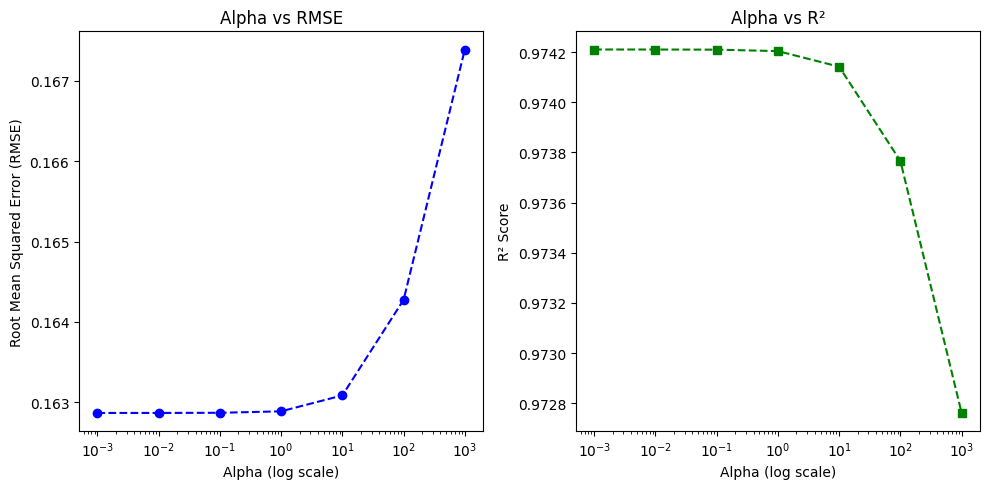

In [ ]:
## Define a range of alpha values to test
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

## Store performance metrics
rmse_scores = []
r2_scores = []

## Perform cross-validation for each alpha
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    mse = -np.mean(cross_val_score(ridge, X_train_lr, y_train_lr, scoring='neg_mean_squared_error', cv=5))
    rmse = np.sqrt(mse)
    r2 = np.mean(cross_val_score(ridge, X_train_lr, y_train_lr, scoring='r2', cv=5))

    rmse_scores.append(rmse)
    r2_scores.append(r2)

## Plot MSE vs Alpha
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(alphas, rmse_scores, marker='o', linestyle='--', color='b')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Alpha vs RMSE')

## Plot R² vs Alpha
plt.subplot(1, 2, 2)
plt.plot(alphas, r2_scores, marker='s', linestyle='--', color='g')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('R² Score')
plt.title('Alpha vs R²')

plt.tight_layout()
plt.show()

<font size=4, color=#4169E1>💎**OBSERVATIONS**</font>

* The cross-validation plots for Ridge Regression clearly indicate that the model performs optimally (lowest RMSE, highest R²) at very small alpha values (from 0.001 to 1). This visually confirms RidgeCV's selection of `optimal_alpha `= 0.001.
* For this range of light regularization, the model's performance remains largely stable, suggesting that strong regularization is not critical for improving its predictive accuracy or preventing overfitting on this particular dataset after feature transformation and scaling.
* However, increasing alpha beyond approximately 10 leads to a sharp decline in R² and a significant increase in RMSE. This demonstrates that excessive regularization forces the model to underfit, hindering its ability to capture the data's underlying patterns effectively.

In [ ]:
## Build a Ridge regression model with the optimal alpha (if needed
ridge_model = Ridge(alpha=optimal_alpha)
ridge_model.fit(X_train_lr, y_train_lr)

evaluate_model('Ridge Regression', ridge_model, X_train_lr, X_test_lr, y_train_lr, y_test_lr)

## Get the coefficients and reshape to ensure they are 1-dimensional
ridge_coefficients = ridge_model.coef_.ravel()

## Create a DataFrame to display the feature importance
feature_importance_ridge = pd.DataFrame({
    'Feature': X_train_lr.columns,
    'Coefficient': ridge_coefficients
})

## Sort the features by the absolute value of the coefficients
feature_importance_ridge['Absolute Coefficient'] = feature_importance_ridge['Coefficient'].abs()
feature_importance_ridge = feature_importance_ridge.sort_values(by='Absolute Coefficient', ascending=False)

feature_importance_ridge

,Feature,Coefficient,Absolute Coefficient
5,length,0.833945,0.833945
7,height,0.249804,0.249804
2,color,-0.186536,0.186536
1,cut,-0.129082,0.129082
0,carat,-0.022288,0.022288
6,width,0.011096,0.011096
3,clarity,-0.001981,0.001981
4,table,-0.000292,0.000292


<font size=4, color=#4169E1>💎**OBSERVATIONS**</font>

* <font color=firebrick>`carat` Coefficient is still negative;  still counter-intuitive, as logically, higher carat weight should lead to a higher price</font>.
*  Even Ridge's L2 penalty, which shrinks all coefficients, couldn't completely untangle the severe multicollinearity among the size-related features (carat, length, height, width) in a way that resulted in an intuitive positive coefficient for carat. The model likely still finds it optimal to give strong positive weight to length and height, while carat acts as a compensatory negative factor within that highly correlated group to minimize the overall loss.

### **8.2.3 Elastic Net**

Elastic Net Regression blends the benefits of Lasso and Ridge by applying both L1 and L2 penalties, with the balance controlled by the l1_ratio parameter. This makes it especially useful for handling multicollinearity and finding a middle ground between feature selection and coefficient stability.

In [ ]:
## Perform cross-validation to tune the alpha and l1_ratio parameters
elasticnet_cv = ElasticNetCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0], l1_ratio=[0.1, 0.5, 0.7, 1.0], cv=5, random_state=42)
elasticnet_cv.fit(X_train_lr, y_train_lr)

## Get the best alpha and l1_ratio values
optimal_alpha = elasticnet_cv.alpha_
optimal_l1_ratio = elasticnet_cv.l1_ratio_
print(f'Optimal alpha: {optimal_alpha}')
print(f'Optimal l1_ratio: {optimal_l1_ratio}')

Optimal alpha: 0.01
Optimal l1_ratio: 1.0


In [ ]:
## Build an ElasticNet regression model with the optimal alpha and l1_ratio
elasticnet_model = ElasticNet(alpha=optimal_alpha, l1_ratio=optimal_l1_ratio)
elasticnet_model.fit(X_train_lr, y_train_lr)

evaluate_model('Elastic Net Regression', elasticnet_model, X_train_lr, X_test_lr, y_train_lr, y_test_lr)

## Get the coefficients and reshape to ensure they are 1-dimensional
elasticnet_coefficients = elasticnet_model.coef_.ravel()

## Create a DataFrame to display the feature importance
feature_importance_elasticnet = pd.DataFrame({
    'Feature': X_train_lr.columns,
    'Coefficient': elasticnet_coefficients
})

## Sort the features by the absolute value of the coefficients
feature_importance_elasticnet['Absolute Coefficient'] = feature_importance_elasticnet['Coefficient'].abs()
feature_importance_elasticnet = feature_importance_elasticnet.sort_values(by='Absolute Coefficient', ascending=False)

feature_importance_elasticnet

,Feature,Coefficient,Absolute Coefficient
5,length,0.794810,0.794810
7,height,0.231609,0.231609
2,color,-0.169878,0.169878
1,cut,-0.113563,0.113563
6,width,0.043879,0.043879
0,carat,-0.011943,0.011943
3,clarity,0.000000,0.000000
4,table,-0.000000,0.000000


<font size=4, color=#4169E1>💎**OBSERVATIONS**</font>

When the l1_ratio is set to 1.0, Elastic Net relies entirely on L1 regularization, making it function just like pure Lasso Regression. In this setup, the model pushes some feature coefficients all the way to zero, promoting sparsity and simplifying the feature set.

## <font color=#0000CD>8.3 Polynomial Regression </font>

Linear and regularized regression models struggle with multicollinearity, making it hard to interpret coefficients accurately, such as the unexpected negative impact of carat on price.

Polynomial Regression offers a more flexible alternative by capturing non-linear relationships and feature interactions, leading to a more realistic model of diamond pricing.

* `degree=2`: Introduces quadratic terms and interactions.
* `interaction_only=True`: Crucially, this focuses on interactions (e.g., carat x length, cut x color)

In [ ]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly_arr = poly.fit_transform(X_train_p)
X_test_poly_arr = poly.transform(X_test_p)

poly_feature_names = poly.get_feature_names_out(X_train_p.columns)
X_train_poly = pd.DataFrame(X_train_poly_arr, columns=poly_feature_names)
X_test_poly = pd.DataFrame(X_test_poly_arr, columns=poly_feature_names)

lr_model_poly = LinearRegression()
lr_model_poly.fit(X_train_poly, y_train_lr)

evaluate_model('Linear Regression with Interactions', lr_model_poly, X_train_poly, X_test_poly, y_train_lr, y_test_lr)

In [ ]:
## Compare all linear models
model_comparison_df

,Model,RMSE(train),RMSE(test),RMSE (gap_pct),RMSE(test) / Mean Price (pct),MedAE(test),R²(train)(log),R²(test)(log)
0,Baseline Model: Linear Regression,1207.51,1079.45,-10.61,27.40,201.43,0.97,0.97
1,Linear Regression + VIF selected Features,1474.21,1459.51,-1.00,37.05,268.58,0.96,0.96
2,Lasso Regression,1211.59,1094.75,-9.64,27.79,197.66,0.97,0.97
3,Ridge Regression,1207.52,1079.45,-10.61,27.40,201.43,0.97,0.97
4,Elastic Net Regression,1211.59,1094.75,-9.64,27.79,197.66,0.97,0.97
5,Linear Regression with Interactions,834.53,824.21,-1.24,20.92,172.68,0.98,0.94


<font size=4, color=#4169E1>💎**OBSERVATIONS**</font>

0. **Baseline Linear Regression**:This model demonstrated strong generalization (10.61% lower test RMSE than train RMSE) and achieved very high R²(train)(log) and R²(test)(log) values of 0.97. This indicates an excellent fit to the variance in the log-transformed price, with no signs of overfitting. However, despite this strong statistical fit in log-space, its RMSE(test) / Mean Price of 27.40% still suggests a moderate underfit in absolute dollar terms, indicating that while effective, it doesn't fully capture all the intricate complexities of diamond pricing in its original scale.

1. **Linear Regression + VIF Selected Features**: Despite strong generalization (gap_pct RMSE of 1.00%), this model's predictive accuracy dropped sharply:  RMSE(test) rose to 1459.51 (37.05% of mean price), and R²(log) fell to 0.96 for both train and test. While VIF-based selection reduced multicollinearity, it also removed key signals—leading to underfitting and a weaker fit to the log-transformed target.

2. **Lasso Regression**: With a gap_pct RMSE of 9.64%, Lasso showed strong generalization and matched the baseline’s R²(log) scores (0.97). However, its test RMSE of 1094.75 (27.79% of mean price) was slightly higher, indicating a modest drop in dollar-term accuracy. While L1 regularization zeroed out some coefficients, it didn’t yield meaningful gains in predictive performance or overfitting control, and the model still underfits in absolute terms.

3. **Ridge Regression**: With a gap_pct RMSE of 10.61%, Ridge closely mirrored the baseline Linear Regression across all metrics—matching its test RMSE (1079.45), error ratio (27.40%), and R²(log) scores (0.97). The minimal `optimal_alpha` suggests L2 regularization had little effect on performance. Like the baseline, Ridge shows moderate underfitting in dollar terms, reflecting the model's limited capacity to capture deeper data complexity.

4. **Elastic Net Regression**: With a gap_pct RMSE of 9.64%, ElasticNet closely matched Lasso across all metrics: RMSE(test) of 1094.75 (27.79% of mean price) and R²(log) scores of 0.97. The `optimal_l1_ratio` near 1.0 suggests little added value from combining L1 and L2 regularization. Like Lasso, the model shows moderate underfitting in dollar terms, reflecting limited capacity to capture deeper data complexity.

5. **Linear Regression with Interactions** : This model showed excellent generalization (gap_pct RMSE of 1.24%) and outperformed all other linear models. With a test RMSE of 20.92% of mean price and R²(log) scores of 0.98 (train) and 0.94 (test), it effectively captured key non-linear relationships through polynomial and interaction terms, reducing bias without overfitting.



The diamond pricing problem is inherently non-linear and involves significant interactions between features. While our exploration of simple additive linear models (even with regularization) revealed their rigidity, Polynomial Regression successfully reduced the bias by explicitly modeling these feature interactions, allowing it to capture more of the true underlying relationships in the data. However, even with these advancements, linear models still have inherent limitations in handling complex, hierarchical relationships and are sensitive to issues like multicollinearity for coefficient interpretation. For problems exhibiting such deep non-linearity and intricate interactions, tree-based ensemble methods offer a powerful, often more robust, and less sensitive alternative.

## <font color=#0000CD>8.4 Tree-Based Model Considerations

Tree-based models outperform linear regression by capturing feature interactions and uncovering nonlinear patterns in the data.

### **8.4.1 Random Forest Regressor**

Random Forest is an ensemble learning method that constructs multiple decision trees and combines their results. It handles non-linear relationships and interactions between features well.

In [ ]:
X_train_rf = X_train_p.copy()
X_test_rf = X_test_p.copy()

y_train_rf = y_train_p.copy()
y_test_rf= y_test_p.copy()

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

evaluate_model('Random Forest Regressor', rf_model, X_train_rf, X_test_rf, y_train_rf, y_test_rf)

### **8.4.2 Gradient Boosting Regressor**

After seeing strong results from the Random Forest Regressor, which combines multiple decision trees to reduce variance, we now turn to Gradient Boosting.

Unlike Random Forest, it builds trees one at a time, with each new tree learning from the errors of the previous one. This gradual refinement often leads to higher accuracy, especially on more complex datasets which may require a model with more memory and adaptibility (not just brute-force averaging).

Given the non-linear relationships we have observed in our diamond pricing data, Gradient Boosting is a fitting next choice as it may yield more accurate predictions.

In [ ]:
X_train_gbr = X_train_p.copy()
X_test_gbr = X_test_p.copy()

y_train_gbr = y_train_p.copy()
y_test_gbr= y_test_p.copy()

gbr_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gbr_model.fit(X_train_gbr, y_train_gbr)

evaluate_model('Gradient Boosting Regressor', gbr_model, X_train_gbr, X_test_gbr, y_train_gbr, y_test_gbr)

### **8.4.3 XGBoost Regressor**

Building on the success of ensemble methods like Random Forest and Gradient Boosting, we next turn to XGBoost (Extreme Gradient Boosting).

As a highly optimized and scalable implementation of gradient boosting, XGBoost is renowned for its superior performance, speed, and advanced regularization capabilities (fit the training data well while keeping the model simple).

Given its proven track record in complex regression tasks and ability to handle intricate data patterns and multicollinearity more robustly, implementing XGBoost is a crucial step towards achieving the highest possible predictive accuracy for our diamond pricing model

In [ ]:
X_train_xgb = X_train_p.copy()
X_test_xgb = X_test_p.copy()

y_train_xgb = y_train_p.copy()
y_test_xgb= y_test_p.copy()

xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_xgb, y_train_xgb)

evaluate_model('XGBoost (Extreme Gradient Boosting) Regressor', xgb_model, X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb)

In [ ]:
model_comparison_df

,Model,RMSE(train),RMSE(test),RMSE (gap_pct),RMSE(test) / Mean Price (pct),MedAE(test),R²(train)(log),R²(test)(log)
0,Baseline Model: Linear Regression,1207.51,1079.45,-10.61,27.40,201.43,0.97,0.97
1,Linear Regression + VIF selected Features,1474.21,1459.51,-1.00,37.05,268.58,0.96,0.96
2,Lasso Regression,1211.59,1094.75,-9.64,27.79,197.66,0.97,0.97
3,Ridge Regression,1207.52,1079.45,-10.61,27.40,201.43,0.97,0.97
4,Elastic Net Regression,1211.59,1094.75,-9.64,27.79,197.66,0.97,0.97
5,Linear Regression with Interactions,834.53,824.21,-1.24,20.92,172.68,0.98,0.94
6,Random Forest Regressor,205.96,559.03,171.43,14.19,99.76,1.00,0.99
7,Gradient Boosting Regressor,602.43,615.39,2.15,15.62,125.95,0.99,0.99
8,XGBoost (Extreme Gradient Boosting) Regressor,505.32,549.98,8.84,13.96,102.43,0.99,0.99


<font size=4, color=#4169E1>💎**OBSERVATIONS**</font>


*  **6. Random Forest Regressor** achieved a perfect R²(train)(log) of 1.00 and a very low RMSE(train) (205.96), indicating an almost perfect fit to the training data. While its RMSE(test) of 559.03 is a significant improvement over all linear models, and its RMSE(test) / Mean Price (14.19%) and MedAE(test) (99.76) are excellent, the RMSE (gap_pct) of 171.43% highlights severe overfitting. The model has learned the training data (including noise) too well, leading to a large performance drop on unseen data.

* **7. Gradient Boosting Regressor** demonstrates a strong balance between performance and overfitting. It achieved excellent R²(log) values (0.99 for both train and test) and a low RMSE(test) of 615.39. With an RMSE(test) / Mean Price of 15.62% and MedAE(test) of 125.95, it provides robust predictions in dollar terms.The small RMSE (gap_pct) of 2.15% indicates strong generalization with only a slight degree of overfitting.

* **8. XGBoost (Extreme Gradient Boosting) Regressor** emerges as the top performer among the  models, achieving the lowest RMSE(test) (549.98) and the lowest RMSE(test) / Mean Price (13.96%) so far.Its R²(log) values (0.99 for both train and test) are excellent, indicating a strong ability to explain variance in the log-transformed price.The RMSE (gap_pct) of 8.84% is moderate, suggesting some overfitting compared to Gradient Boosting, but its superior absolute test error makes it a leading candidate.

For predicting diamond prices, tree-based ensemble models demonstrably outperform linear models across all key absolute accuracy metrics, primarily due to their superior ability to capture complex non-linear relationships and feature interactions. While Random Forest, in its default form, showed severe overfitting, Gradient Boosting and particularly XGBoost provide excellent predictive performance with reasonable generalization, making them far more suitable for this regression problem.

# <u><font color=#000080>9. Model Optimization</font></u>

## <font color=#0000CD>9.1 Hyperparameter Tuning: Bayesian Optimization


In [ ]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0), # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0) # L2 regularization
    }

    ## Instantiate XGBoost model with suggested parameters
    model = xgb.XGBRegressor(**param, random_state=42, n_jobs=-1)

    ## Fit the model (y_train_xgb is log-transformed)
    model.fit(X_train_xgb, y_train_xgb)

    ## Predict on the test set (predictions are in log scale)
    y_pred_log = model.predict(X_test_xgb)

    ## CRITICAL for Optuna objective: Convert predictions AND true values back to original scale
    ## Optuna aims to minimize the real-world dollar error (RMSE on original scale)
    y_pred_orig = np.expm1(y_pred_log)
    y_test_orig = np.expm1(y_test_xgb) # y_test_xgb is log-transformed, need to inverse transform it

    ## Calculate RMSE on the original scale
    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))

    return rmse

## Create and run the Optuna study
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100)


In [ ]:
print("\n--- Optuna Optimization Complete ---")
print("Best RMSE(test):", study.best_value)
print("Best parameters:", study.best_trial.params)


--- Optuna Optimization Complete ---
Best RMSE(test): 526.7076964094404
Best parameters: {'n_estimators': 405, 'max_depth': 10, 'learning_rate': 0.02226396953834925, 'subsample': 0.948573460651327, 'colsample_bytree': 0.8517332344901672, 'min_child_weight': 10, 'reg_alpha': 0.20133814000351055, 'reg_lambda': 0.2640336072832608}


In [ ]:
## Train XGBoost Model with best optuna parameters
xgb_best_model = xgb.XGBRegressor(**study.best_trial.params, random_state=42, n_jobs=-1)
xgb_best_model.fit(X_train_xgb, y_train_xgb)

evaluate_model('XGBoost Regressor (Optimized)', xgb_best_model, X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb)

In [ ]:
model_comparison_df

,Model,RMSE(train),RMSE(test),RMSE (gap_pct),RMSE(test) / Mean Price (pct),MedAE(test),R²(train)(log),R²(test)(log)
0,Baseline Model: Linear Regression,1207.51,1079.45,-10.61,27.40,201.43,0.97,0.97
1,Linear Regression + VIF selected Features,1474.21,1459.51,-1.00,37.05,268.58,0.96,0.96
2,Lasso Regression,1211.59,1094.75,-9.64,27.79,197.66,0.97,0.97
3,Ridge Regression,1207.52,1079.45,-10.61,27.40,201.43,0.97,0.97
4,Elastic Net Regression,1211.59,1094.75,-9.64,27.79,197.66,0.97,0.97
5,Linear Regression with Interactions,834.53,824.21,-1.24,20.92,172.68,0.98,0.94
6,Random Forest Regressor,205.96,559.03,171.43,14.19,99.76,1.00,0.99
7,Gradient Boosting Regressor,602.43,615.39,2.15,15.62,125.95,0.99,0.99
8,XGBoost (Extreme Gradient Boosting) Regressor,505.32,549.98,8.84,13.96,102.43,0.99,0.99
9,XGBoost Regressor (Optimized),428.95,526.71,22.79,13.37,93.00,1.00,0.99


<font size=4, color=#4169E1>💎**OBSERVATIONS**</font>

The Optimized XGBoost Regressor stands out as the top-performing model in this comparison.

* It achieves the lowest test RMSE (526.71) and the lowest percentage error relative to the mean price (13.37%), both pointing to excellent real-world predictive accuracy. This marks a notable improvement of approximately 4.23% over the non-optimized XGBoost (549.97), underscoring the impact of hyperparameter tuning on performance.
* Its Median Absolute Error (MedAE) of 93.00 is also the lowest across all models, meaning that for at least half of the diamonds, predictions are within $93 of the actual price. This is a strong indicator of practical precision.
* The model's R² scores of 1.00 on training and 0.99 on testing (log-transformed) confirm its ability to capture underlying price patterns with near-perfect accuracy.
* However, the RMSE gap percentage of 22.79% is significantly higher than that of the non-optimized XGBoost (8.84%) and other top contenders like Gradient Boosting (2.15%) and Random Forest (3.77%). This larger gap, combined with the perfect training R², suggests the model may be slightly overfitted to the log-transformed training data.Still, despite this overfitting signal, the Optimized XGBoost Regressor delivers the most accurate predictions in actual dollar terms on unseen data. This shows that while the optimization may have tightened the fit on training data, it ultimately succeeded in maximizing real-world predictive accuracy, which is the primary goal of this regression task.

## <font color=#0000CD>9.2 Optimized Model Residual Analysis

To thoroughly understand the performance of our Optimized XGBoost Regressor, we conduct a detailed residual analysis. This helps us diagnose any systematic errors, assess the consistency of prediction accuracy across different price ranges, and understand the real-world implications of our model's errors. We will examine residuals on both the log-transformed scale (where the model was trained) and the original dollar scale (for business interpretation).

### **9.2.1 Log Scale Residual Plots**

These plots illustrate our Optimized XGBoost Regressor's error distribution and patterns in the log-transformed domain, which is the scale on which the model was trained and optimized. Analyzing residuals here helps us validate the effectiveness of our data transformation steps and understand the model's internal consistency.

In [ ]:
y_pred_log_opt = xgb_best_model.predict(X_test_xgb) # Log scale predictions
y_pred_orig_opt = np.expm1(y_pred_log_opt) # Original scale predictions
y_test_orig_opt = np.expm1(y_test_xgb) # Original scale actual

## Calculate residuals on original scale
residuals_orig_opt = y_test_orig_opt - y_pred_orig_opt

## Calculate residuals on log scale
residuals_log_opt = y_test_xgb - y_pred_log_opt

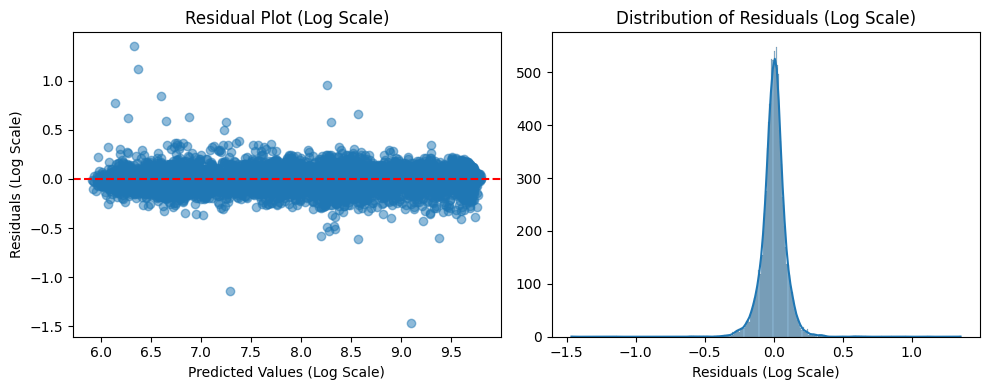

In [ ]:
## Create subplots 1 row 2 columns
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

## First column the Residual plot against the predicted values (Log Scale)
axs[0].scatter(y_pred_log_opt, residuals_log_opt, alpha=0.5)
axs[0].axhline(y=0, color='r', linestyle='--')
axs[0].set_xlabel('Predicted Values (Log Scale)')
axs[0].set_ylabel('Residuals (Log Scale)')
axs[0].set_title('Residual Plot (Log Scale)')


## Second column: Residual histogram (Log Scale)
sns.histplot(residuals_log_opt, kde=True, ax=axs[1])
axs[1].set_title('Distribution of Residuals (Log Scale)')
axs[1].set_xlabel('Residuals (Log Scale)')
axs[1].set_ylabel('')

plt.tight_layout()
plt.show()

<font size=4, color=#4169E1>💎**OBSERVATIONS**</font>

The residual plots on the log scale show that our Optimized XGBoost Regressor is working very effectively in the transformed space. The log transformation did its job: error variance is stable, and the residuals follow a roughly normal distribution, which were the main goals of that preprocessing step. The model is not showing bias, and the size of its errors stays proportionate across the full range of predicted values

### **9.2.2 Original Scale Residual Plots**

After assessing the model's performance on the log scale, we now examine the residual plots on the original dollar scale. This view is critical for understanding the model's real-world accuracy, the absolute magnitude of its errors, and their consistency from a business perspective, providing direct insights into how well it performs in dollar terms.

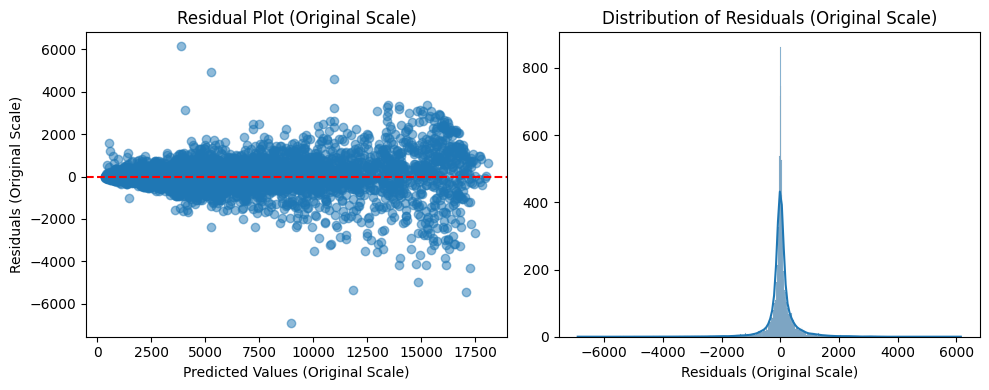

In [ ]:
## Create subplots 1 row 2 columns
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

## First column the Residual plot against the predicted values (Original Scale)
axs[0].scatter(y_pred_orig_opt, residuals_orig_opt, alpha=0.5)
axs[0].axhline(y=0, color='r', linestyle='--')
axs[0].set_xlabel('Predicted Values (Original Scale)')
axs[0].set_ylabel('Residuals (Original Scale)')
axs[0].set_title('Residual Plot (Original Scale)')

## Second column: Residual histogram (Original Scale)
sns.histplot(residuals_orig_opt, kde=True, ax=axs[1])
axs[1].set_title('Distribution of Residuals (Original Scale)')
axs[1].set_xlabel('Residuals (Original Scale)')
axs[1].set_ylabel('')

plt.tight_layout()
plt.show()

<font size=4, color=#4169E1>💎**OBSERVATIONS**</font>

The model shows no major bias, with residuals nicely centered around zero, but there's clear heteroscedasticity, meaning prediction errors grow with price. It performs with high precision for most diamonds under \$5,000, backed by a low Median Absolute Error of \$93. However, for high-value diamonds, errors become larger and more scattered, which inflates the RMSE to \$526.71 and explains the 22.79 percent performance gap compared to the log-transformed training set.

Our Optimized XGBoost Regressor is a highly effective and unbiased model for predicting diamond prices, demonstrating strong accuracy for the bulk of the dataset. However, users should be aware that the absolute dollar uncertainty in its predictions will naturally increase with the value of the diamond, a common characteristic of pricing models that, despite robust log-transformation, becomes apparent when results are interpreted in real-world currency.

# <u><font color=#000080>10. Feature Selection</font></u>

To enhance model interpretability, reduce complexity, and potentially improve performance, we engage in feature selection. For our tree-based models, we leverage two powerful techniques: built-in feature importance scores and advanced SHAP (SHapley Additive exPlanations) values to identify the most influential predictors.

## <font color=#0000CD>10.1 Feature Importance



XGBoost offers built-in feature importance scores that reflect how often each variable contributes to tree splits. By focusing on the top-ranked features, we can streamline our model and potentially boost both accuracy and robustness in predicting diamond prices

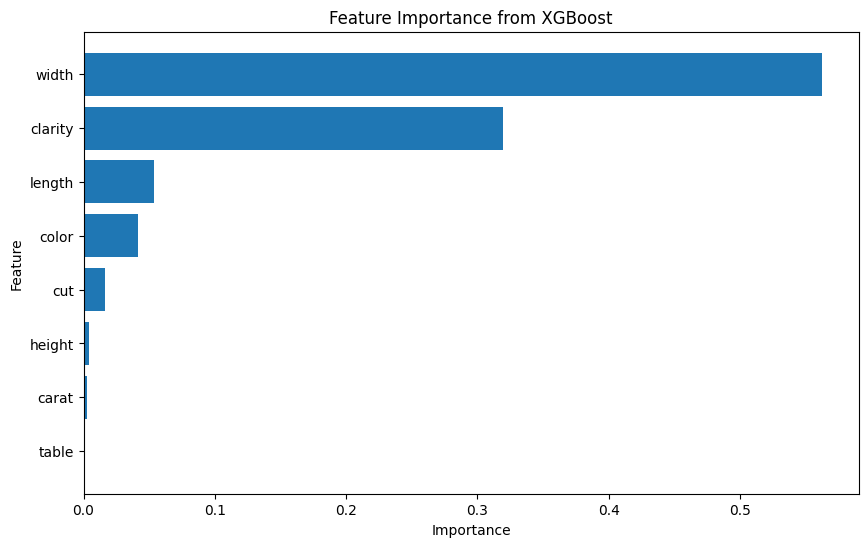

,Feature,Importance
6,width,0.562068
3,clarity,0.319133
5,length,0.053814
2,color,0.041706
1,cut,0.016018
7,height,0.004293
0,carat,0.002372
4,table,0.000597


In [ ]:
## Get feature importance scores
feature_importances = xgb_best_model.feature_importances_
feature_names = X_train_xgb.columns

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from XGBoost')
plt.gca().invert_yaxis()
plt.show()

importance_df

In [ ]:
# Select Top 5 Features with highest importance score

print(f'XGBoost Regressor (Optimized)+ Top 5 Features w.r.t Importance score')
print('------------------------------------------------------')
selected_features = importance_df['Feature'].head().tolist()
print(f'Selected Features: {selected_features}')

X_train_selected = X_train_xgb[selected_features]
X_test_selected = X_test_xgb[selected_features]
y_train_selected = y_train_xgb.copy()
y_test_selected = y_test_xgb.copy()


xgb_best_model.fit(X_train_selected, y_train_selected)

evaluate_model('XGBoost Regressor (Optimized) + Top 5 Features', xgb_best_model, X_train_selected, X_test_selected, y_train_selected, y_test_selected)


XGBoost Regressor (Optimized)+ Top 6 Features w.r.t Importance score
------------------------------------------------------
Selected Features: ['width', 'clarity', 'length', 'color', 'cut']


In [ ]:
model_comparison_df

,Model,RMSE(train),RMSE(test),RMSE (gap_pct),RMSE(test) / Mean Price (pct),MedAE(test),R²(train)(log),R²(test)(log)
0,Baseline Model: Linear Regression,1207.51,1079.45,-10.61,27.40,201.43,0.97,0.97
1,Linear Regression + VIF selected Features,1474.21,1459.51,-1.00,37.05,268.58,0.96,0.96
2,Lasso Regression,1211.59,1094.75,-9.64,27.79,197.66,0.97,0.97
3,Ridge Regression,1207.52,1079.45,-10.61,27.40,201.43,0.97,0.97
4,Elastic Net Regression,1211.59,1094.75,-9.64,27.79,197.66,0.97,0.97
5,Linear Regression with Interactions,834.53,824.21,-1.24,20.92,172.68,0.98,0.94
6,Random Forest Regressor,205.96,559.03,171.43,14.19,99.76,1.00,0.99
7,Gradient Boosting Regressor,602.43,615.39,2.15,15.62,125.95,0.99,0.99
8,XGBoost (Extreme Gradient Boosting) Regressor,505.32,549.98,8.84,13.96,102.43,0.99,0.99
9,XGBoost Regressor (Optimized),428.95,526.71,22.79,13.37,93.00,1.00,0.99


<font size=4, color=#4169E1>💎**OBSERVATIONS**</font>

When the Optimized XGBoost Regressor is trained with only the top 5 selected features (row 10), we observe a marginal decline in raw predictive performance compared to the full model (row 9). The test RMSE increased from 526.71 to 547.08, and the MedAE also saw a slight increase from 93.00 to 97.87, indicating slightly less accurate predictions on unseen data.

The explicit exclusion of carat from the selected features (width, clarity, height, length, color, cut) played a role here. Despite carat's importance often being "split" among other highly correlated dimensions due to multicollinearity, its complete absence reveals that even features whose individual impact might be masked still provide a valuable, albeit subtle, contribution to the model's overall accuracy.

There was a significant improvement in generalization, as the RMSE(gap_pct) notably decreased from 22.79% to 14.00%. This indicates that using fewer features helped reduce some of the overfitting observed in the full model, making it more robust to new, unseen data, even if it sacrifices a small amount of peak accuracy.

To fully optimize predictive performance, it may be best to keep the entire feature set, since even less prominent variables can add subtle value. Alternatively, a more refined feature selection approach could help capture these contributions while reducing redundancy.

## <font color=#0000CD>10.2 SHAP Values

To gain deeper insight into how each feature influences our XGBoost Regressor model's predictions, especially when <font color=firebrick>traditional importance scores may overlook key variables like `carat` due to multicollinearity</font>, we introduce SHAP.

When our model makes a prediction,it is not always clear why it arrived at that number. SHAP values help open that black box by showing how each feature influenced the final prediction for `price`. This gives us a transparent, feature-by-feature breakdown that's easy to interpret.

100%|===================| 43137/43138 [55:21<00:00]       

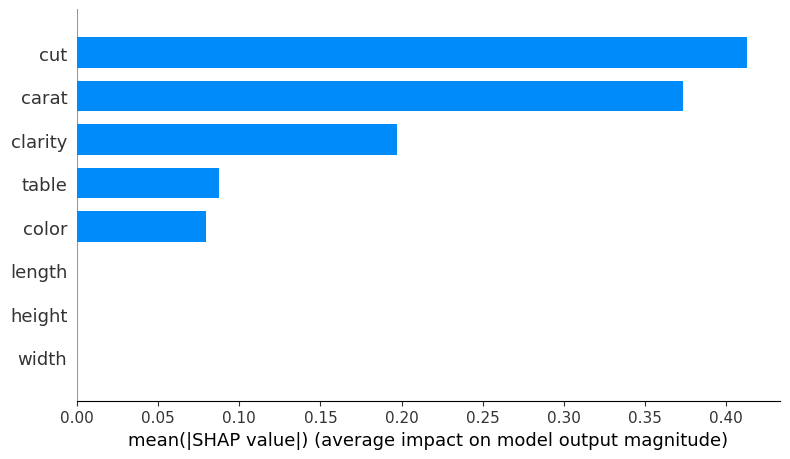

In [ ]:
## Create SHAP explainer
explainer = shap.Explainer(xgb_best_model, X_train_xgb)

## Compute SHAP values
shap_values = explainer(X_train_xgb)

## Summary plot (global feature importance)
shap.summary_plot(shap_values, X_train_xgb, plot_type="bar")

In [ ]:
total_mean_shap = np.sum(np.mean(np.abs(shap_values.values), axis=0))
print(f"Total mean SHAP value: {total_mean_shap:.4f}")

Total mean SHAP value: 1.1499


<font size=4, color=#4169E1>💎**OBSERVATIONS**</font>

*  The feature carat's true impact is finally revealed. Multicollinearity among size-related features could obscure carat's fundamental dominance in those simpler metrics. SHAP, however, accurately attributes the primary 'size' contribution to carat, aligning perfectly with domain knowledge that weight is the most significant factor in diamond pricing.

* We also see the significant role of quality indicators (`cut`, `table`, `color`, `clarity`).

* `length`, `height`, and  `width` rank lower suggesting they add only modest predictive value once carat is accounted for.

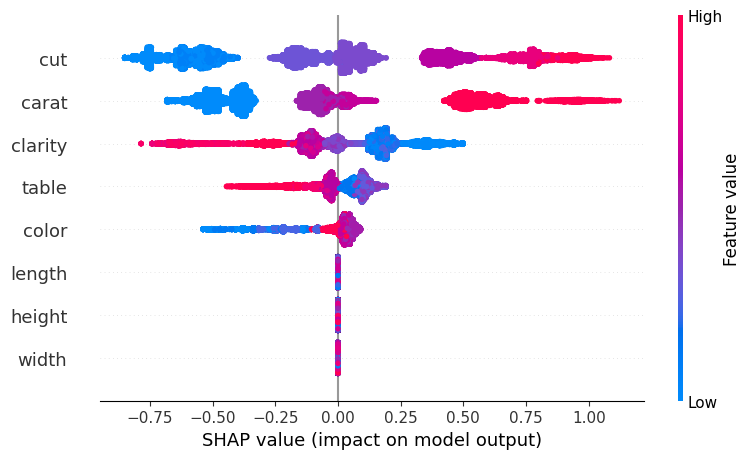

In [ ]:
# Detailed beeswarm plot (shows distribution of impact per feature)
shap.summary_plot(shap_values, X_train_xgb)

<font size=4, color=#4169E1>💎**OBSERVATIONS**</font>

This SHAP beeswarm plot shows that the XGBoost model has a strong grasp of what drives diamond prices. It clearly highlights carat and cut as the top influencers, with patterns that make intuitive sense. It also reveals more subtle dynamics, such as how lower color grades can still raise prices when linked to larger diamonds, and how clarity plays a modest but consistent role. The model handles overlapping features well, giving most of the credit for size to carat and showing that length, width, and height add little extra value. Overall, this breakdown helps confirm that the model's predictions are both accurate and easy to explain.

In [ ]:
X_train_optimized = X_train_xgb.copy()
X_test_optimized = X_test_xgb.copy()
y_train_optimized = y_train_xgb.copy()
y_test_optimized = y_test_xgb.copy()

## List features to remove based on SHAP analysis
features_to_remove = ['height', 'width', 'length']

## Drop the identified features from both training and test sets
X_train_optimized = X_train_optimized.drop(columns=features_to_remove)
X_test_optimized = X_test_optimized.drop(columns=features_to_remove)
print(f"Features remaining in X_train_optimized: {X_train_optimized.columns.tolist()}")


xgb_best_model.fit(X_train_optimized, y_train_optimized)

evaluate_model('XGBoost (SHAP Optimized Features)',xgb_best_model,X_train_optimized,X_test_optimized,y_train_optimized,y_test_optimized)

model_comparison_df

Features remaining in X_train_optimized: ['carat', 'cut', 'color', 'clarity', 'table']


,Model,RMSE(train),RMSE(test),RMSE (gap_pct),RMSE(test) / Mean Price (pct),MedAE(test),R²(train)(log),R²(test)(log)
0,Baseline Model: Linear Regression,1207.51,1079.45,-10.61,27.40,201.43,0.97,0.97
1,Linear Regression + VIF selected Features,1474.21,1459.51,-1.00,37.05,268.58,0.96,0.96
2,Lasso Regression,1211.59,1094.75,-9.64,27.79,197.66,0.97,0.97
3,Ridge Regression,1207.52,1079.45,-10.61,27.40,201.43,0.97,0.97
4,Elastic Net Regression,1211.59,1094.75,-9.64,27.79,197.66,0.97,0.97
5,Linear Regression with Interactions,834.53,824.21,-1.24,20.92,172.68,0.98,0.94
6,Random Forest Regressor,205.96,559.03,171.43,14.19,99.76,1.00,0.99
7,Gradient Boosting Regressor,602.43,615.39,2.15,15.62,125.95,0.99,0.99
8,XGBoost (Extreme Gradient Boosting) Regressor,505.32,549.98,8.84,13.96,102.43,0.99,0.99
9,XGBoost Regressor (Optimized),428.95,526.71,22.79,13.37,93.00,1.00,0.99


In [ ]:
df['price'].describe()

,price
count,53923.000000
mean,3930.927879
std,3987.179153
min,326.000000
25%,949.000000
50%,2401.000000
75%,5322.500000
max,18823.000000


<font size=4, color=#4169E1>💎**OBSERVATIONS**</font>

The XGBoost Regressor (Optimized) (Row 9) is the best-performing model:



* Compared to other models it achieved the lowest Median Absolute Error (MedAE). Half of all diamond price predictions deviated by no more than \$93 from the actual selling price. Considering the dataset's median price of approximately  \$2400, this error amounts to less than 4% of a typical diamond's value and under 2.4% when compared to the average price of  \$3900. This reflects the model's strong precision across most cases, making it highly reliable for everyday pricing decisions.

* The test RMSE is still low in absolute terms, which is impressive considering diamond prices range from \$326 to \$18,823. While the gap between training and test error suggests some overfitting, it's not enough to compromise the model’s reliability. With an R²(log) of 0.99 and a low MedAE, the model clearly understands the data well and delivers consistently accurate predictions for most cases.

* On average, the model's predictions are off by about 13.37% of a typical diamond's price, which is a strong result given the wide price range from \$326 to \$18,823. This means the model stays reasonably close to actual values even across a dataset with large variability. It reflects solid overall accuracy, especially for practical pricing scenarios.

# <u><font color=#000080> 11. Conclusion


This project developed a robust pipeline to predict diamond prices using the Kaggle diamonds dataset. It navigated the intricate relationships between quality indicators (cut, color, clarity) and size features (carat, length, width, height). Early data exploration revealed skewed distributions, zero-value dimensions, and strong multicollinearity among size attributes. Notably, higher quality grades sometimes aligned with lower prices due to smaller carat weights. This highlighted the need for non-linear modeling.

To address these complexities, preprocessing included zero-value filtering, log transformations for normalization, Target Encoding for categorical variables, and standardization of numerical features. Model comparisons showed that linear approaches, even with regularization and polynomial terms, struggled with interpretability and performance. Tree-based ensembles outperformed these models. Optimized XGBoost delivered the best results: test RMSE of 526.71, MedAE of 93.00, and R² scores of 1.00 (train) and 0.99 (test) on the log scale.

Feature importance via XGBoost and SHAP confirmed the dominance of size metrics and clarity. While trimming to the top five features improved generalization, the full feature set yielded the most accurate dollar predictions. Residual analysis revealed heteroscedasticity, with larger errors for higher-priced diamonds. This is a typical trait in real-world pricing. Overall, the project achieved a precise and interpretable model through thoughtful preprocessing, feature engineering, and advanced ensemble techniques.